In [1]:
import json
import os
import sys
import importlib
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots
import src.utils

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import ttest_1samp, wilcoxon
import statannot

from statsmodels.stats.multitest import fdrcorrection, multipletests

plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')
import pymsfilereader

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import HuberRegressor, LinearRegression
import statsmodels.formula.api as smf

In [162]:
fr = pd.read_csv('../data/search/CD31/peak_finder/Final_Results_CD31.csv')

In [72]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
class_abbrevs = json.load(open('../data/metadata/molec_class_abbrev.json'))

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

data['abbrev'] = data['molec_class'] + ' ' + data['fa_carbon:unsat']

## Database of lipid MS1s from 
`https://www.lipidmaps.org/databases/comp_db/download`

In [24]:
ldb = pd.read_csv('D:/lipidmapsDB/COMP_DB_DATA.tsv', sep='\t')
_, ldb['extra'], ldb['c'], ldb['u'], ldb['sum_comp'], ldb['fa_list'], ldb['is_sum_comp'] = \
    zip(*ldb['abbrev'].apply(src.utils.parse_lipid))

ldb

headgroup        abbrev         mass    formula chain_type extra     c  \
0          ACer  ACer 48:0;O5   797.710854  C48H95NO7       even   NaN   NaN   
1          ACer  ACer 48:0;O6   813.705769  C48H95NO8       even   NaN   NaN   
2          ACer  ACer 48:1;O3   763.705374  C48H93NO5       even   NaN   NaN   
3          ACer  ACer 48:6;O6   801.611869  C48H83NO8       even   NaN   NaN   
4          ACer  ACer 49:0;O2   763.741759  C49H97NO4        odd   NaN   NaN   
...         ...           ...          ...        ...        ...   ...   ...   
60912        TG       TG 65:1  1042.986740  C68H130O6        odd        65.0   
60913        TG       TG 65:8  1028.877190  C68H116O6        odd        65.0   
60914        TG       TG 66:0  1059.018040  C69H134O6       even        66.0   
60915        TG      TG 66:13  1032.814590  C69H108O6       even        66.0   
60916        TG       TG 66:6  1046.924140  C69H122O6       even        66.0   

          u sum_comp     fa_list is_sum_comp  
0       NaN      NaN         NaN         NaN  
1       NaN      NaN         NaN         NaN  
2       NaN      NaN         NaN         NaN  
3       NaN      NaN         NaN         NaN  
4       NaN      NaN         NaN         NaN  
...     ...      ...         ...         ...  
60912   1.0     65:1   [(65, 1)]        True  
60913   8.0     65:8   [(65, 8)]        True  
60914   0.0     66:0   [(66, 0)]        True  
60915  13.0    66:13  [(66, 13)]        True  
60916   6.0     66:6   [(66, 6)]        True  

[60917 rows x 11 columns]

In [13]:
ldb.loc[ldb['abbrev'].str.contains('TG')]

headgroup        abbrev         mass    formula chain_type
50437        TG     TG O-30:0   540.475375   C33H64O5       even
50438        TG   TG O-30:0;O   556.470290   C33H64O6       even
50439        TG  TG O-30:0;O2   572.465205   C33H64O7       even
50440        TG  TG O-30:0;O3   588.460120   C33H64O8       even
50441        TG     TG O-30:1   538.459725   C33H62O5       even
...         ...           ...          ...        ...        ...
60912        TG       TG 65:1  1042.986740  C68H130O6        odd
60913        TG       TG 65:8  1028.877190  C68H116O6        odd
60914        TG       TG 66:0  1059.018040  C69H134O6       even
60915        TG      TG 66:13  1032.814590  C69H108O6       even
60916        TG       TG 66:6  1046.924140  C69H122O6       even

[10480 rows x 5 columns]

# Create nested loops to make lipid names for searching

In [93]:
def make_lipids(lipclass, C, U, O=0):
    if type(C) == int:
        C = [C]
    if type(U) == int:
        U = [U]
    if type(O) == int:
        O = [O]
    names = []
    for c in C:
        for u in U:
            for o in O:
                if o == 0:
                    o_string = ''
                elif o == 1:
                    o_string = f';O'
                elif o > 1:
                    o_string = f';O{o}'
                else:
                    raise ValueError('Oxidations being weird')
                name = f'{lipclass} {c}:{u}{o_string}'
                names.append(name)
    return names

# TG search

In [194]:
lipids = make_lipids('TG', range(30, 80), range(0, 30), range(1, 3))
lipids

tgs = []
for lipid in lipids:
    tgs.append(ldb.loc[ldb['abbrev'] == lipid])
tgs = pd.concat(tgs)

H_mass = 1.00727647
nh4_mass = 	18.034374132
tgs['m/z'] = tgs['mass'] + nh4_mass
tgs

headgroup       abbrev         mass    formula chain_type extra   c   u  \
55676        TG    TG 30:0;O   570.449555   C33H62O7       even   NaN NaN NaN   
55677        TG   TG 30:0;O2   586.444470   C33H62O8       even   NaN NaN NaN   
55680        TG    TG 30:1;O   568.433905   C33H60O7       even   NaN NaN NaN   
55681        TG   TG 30:1;O2   584.428820   C33H60O8       even   NaN NaN NaN   
55684        TG    TG 30:2;O   566.418255   C33H58O7       even   NaN NaN NaN   
...         ...          ...          ...        ...        ...   ...  ..  ..   
58836        TG  TG 79:19;O2  1234.913970  C82H122O8        odd   NaN NaN NaN   
58839        TG   TG 79:20;O  1216.903405  C82H120O7        odd   NaN NaN NaN   
58840        TG  TG 79:20;O2  1232.898320  C82H120O8        odd   NaN NaN NaN   
58843        TG   TG 79:21;O  1214.887755  C82H118O7        odd   NaN NaN NaN   
58844        TG  TG 79:21;O2  1230.882670  C82H118O8        odd   NaN NaN NaN   

      sum_comp fa_list is_sum_comp          m/z  
55676      NaN     NaN         NaN   588.483929  
55677      NaN     NaN         NaN   604.478844  
55680      NaN     NaN         NaN   586.468279  
55681      NaN     NaN         NaN   602.463194  
55684      NaN     NaN         NaN   584.452629  
...        ...     ...         ...          ...  
58836      NaN     NaN         NaN  1252.948344  
58839      NaN     NaN         NaN  1234.937779  
58840      NaN     NaN         NaN  1250.932694  
58843      NaN     NaN         NaN  1232.922129  
58844      NaN     NaN         NaN  1248.917044  

[1608 rows x 12 columns]

In [196]:
matches = []
for i, theoretical_mz in zip(tgs.index, tgs['m/z']):
    for j, measured_mz in zip(data.index, data['m/z']):
        if src.utils.ppm_tol(theoretical_mz, measured_mz, 7):
            ppm_error = src.utils.calc_ppm_error(theoretical_mz, measured_mz)
            matches.append({'theo': theoretical_mz, 'actual': measured_mz, 
                            'data_i': j, 'ldb_i': i, 'ppm_err': ppm_error})
            
matches = pd.DataFrame(matches)
matches = (matches
           .merge(tgs[['c', 'u', 'chain_type', 'm/z', 'abbrev']], left_on='ldb_i', right_index=True)
           .merge(data[['ID', 'superclass', 'molec_class', 'abbrev', 'm/z', 'RT']], left_on='data_i', right_index=True)
          )
matches = matches.loc[(matches['molec_class'].isin(['TG', 'Unidentified']))]
# matches['c'] = matches['c'].astype('str')
# matches['u'] = matches['u'].astype('str')
matches['is_id'] = matches['ID'] != 'Unidentified'

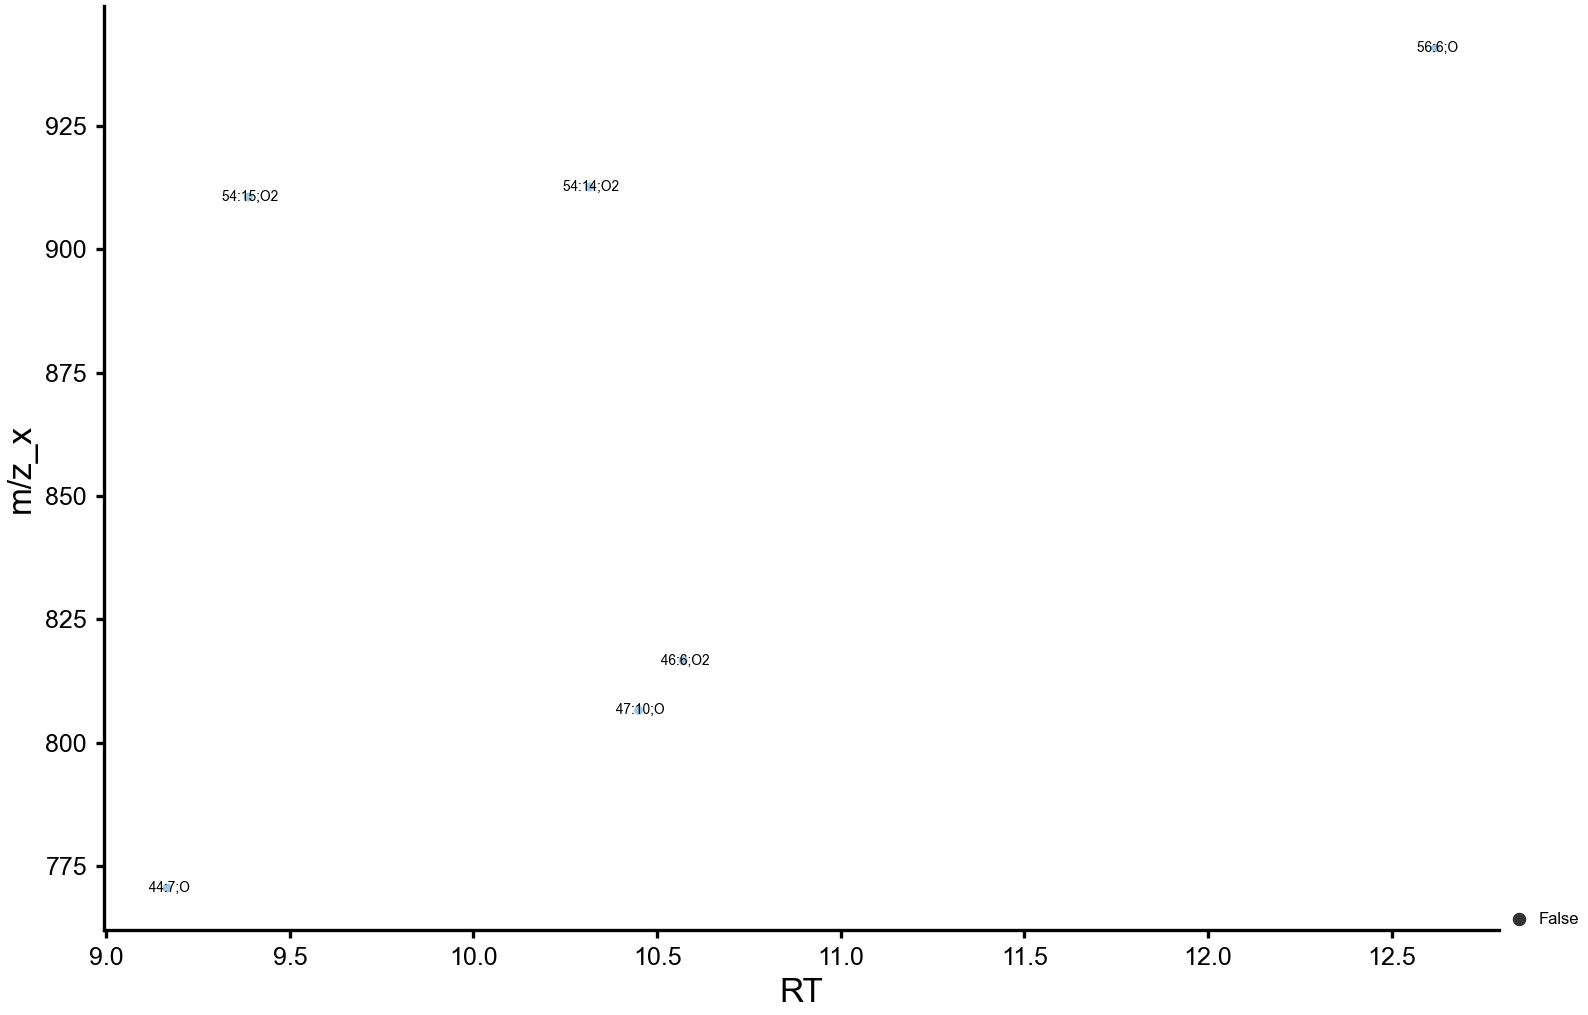

In [197]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
subset = matches.loc[~matches['is_id']]
sns.scatterplot(
    data=subset, 
    x='RT', y='m/z_x', hue='u', palette='viridis', alpha=0.4,
    size='is_id', sizes={True: 10, False: 5},
#     size='ppm_err', 
)


for i, row in subset.iterrows():
#     s = f"{int(row['c'])}:{int(row['u'])}"
    s = row['abbrev_x'][2:]
    ax.text(row['RT'], row['m/z_x'], s, va='center', ha='center', 
            bbox=dict(lw=0, fc='0.9', pad=0, alpha=0.), fontsize=3.3)

ax.legend(loc=(1, 0), fontsize=4)
sns.despine()

<Figure size 768x576 with 0 Axes>

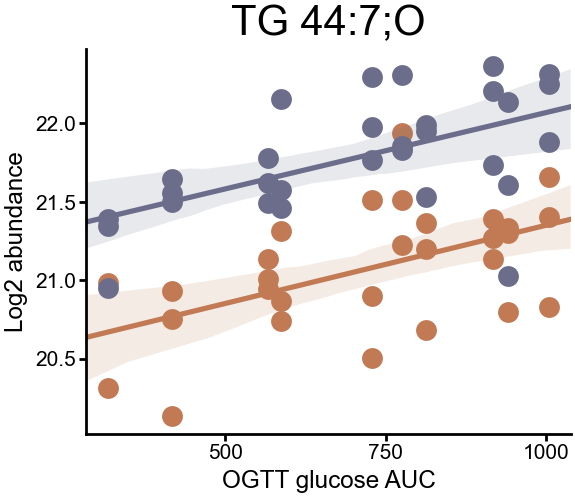

<Figure size 768x576 with 0 Axes>

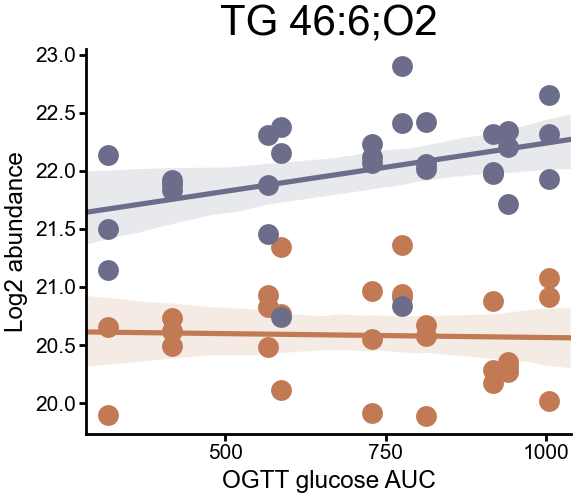

<Figure size 768x576 with 0 Axes>

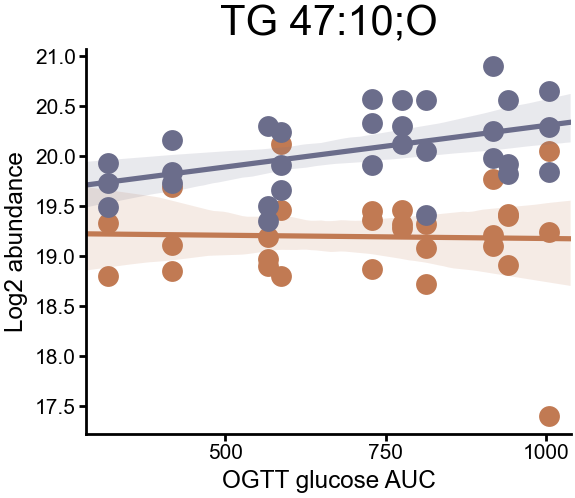

<Figure size 768x576 with 0 Axes>

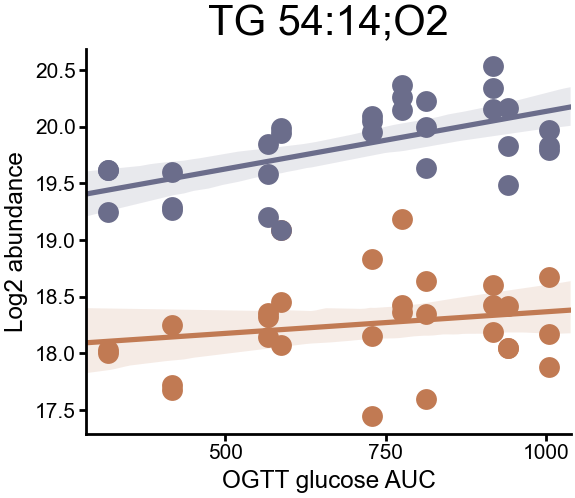

<Figure size 768x576 with 0 Axes>

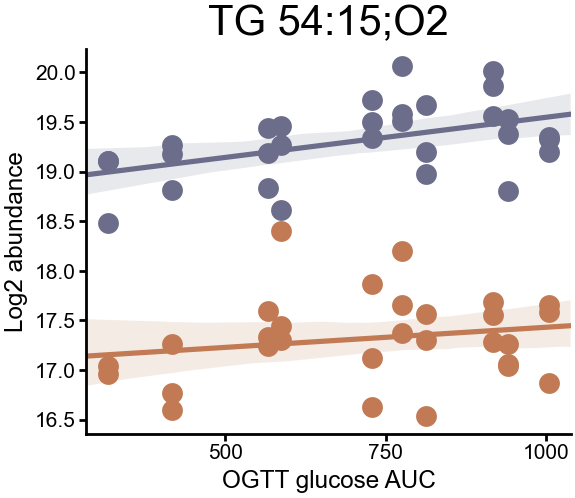

<Figure size 768x576 with 0 Axes>

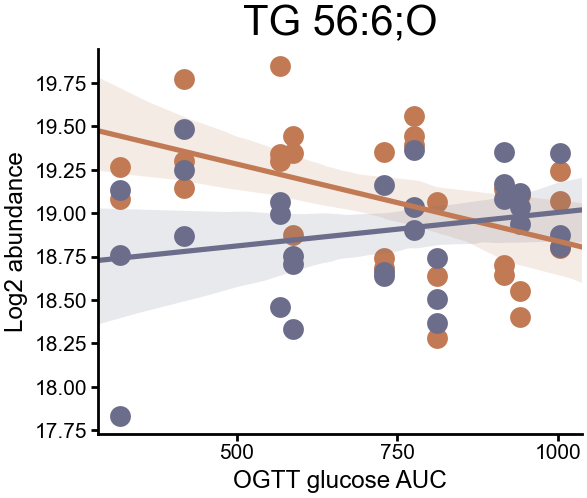

In [198]:
for _, row in subset.iterrows():
    plt.figure()
    src.plots.plot_quant_vs_ogtt(row['data_i'])
    plt.title(row['abbrev_x'])

# CE Search

In [199]:
ce_abbrevs = make_lipids('CE', range(0, 50), range(0, 20), range(0, 3))
ce_abbrevs

ces = []
for lipid in ce_abbrevs:
    ces.append(ldb.loc[ldb['abbrev'] == lipid])
ces = pd.concat(ces)

H_mass = 1.00727647
nh4_mass = 	18.034374132
ces['m/z'] = ces['mass'] + H_mass
ces

headgroup      abbrev        mass    formula chain_type extra     c    u  \
2290        CE     CE 10:0  540.490630   C37H64O2       even        10.0  0.0   
2291        CE   CE 10:0;O  556.485545   C37H64O3       even   NaN   NaN  NaN   
2292        CE  CE 10:0;O2  572.480460   C37H64O4       even   NaN   NaN  NaN   
2295        CE     CE 10:1  538.474980   C37H62O2       even        10.0  1.0   
2296        CE   CE 10:1;O  554.469895   C37H62O3       even   NaN   NaN  NaN   
...        ...         ...         ...        ...        ...   ...   ...  ...   
3078        CE   CE 34:6;O  880.767245  C61H100O3       even   NaN   NaN  NaN   
3079        CE  CE 34:6;O2  896.762160  C61H100O4       even   NaN   NaN  NaN   
3082        CE     CE 34:7  862.756680   C61H98O2       even        34.0  7.0   
3083        CE   CE 34:7;O  878.751595   C61H98O3       even   NaN   NaN  NaN   
3084        CE  CE 34:7;O2  894.746510   C61H98O4       even   NaN   NaN  NaN   

     sum_comp    fa_list is_sum_comp         m/z  
2290     10:0  [(10, 0)]       False  541.497906  
2291      NaN        NaN         NaN  557.492821  
2292      NaN        NaN         NaN  573.487736  
2295     10:1  [(10, 1)]       False  539.482256  
2296      NaN        NaN         NaN  555.477171  
...       ...        ...         ...         ...  
3078      NaN        NaN         NaN  881.774521  
3079      NaN        NaN         NaN  897.769436  
3082     34:7  [(34, 7)]       False  863.763956  
3083      NaN        NaN         NaN  879.758871  
3084      NaN        NaN         NaN  895.753786  

[483 rows x 12 columns]

In [200]:
fr['m/z'] = fr['Quant Ion']
fr['RT'] = fr['Retention Time (min)']
fr['ID'] = fr['Identification']
fr['molec_class'] = fr['Lipid Class']

df = data

ce_matches = []
for i, theoretical_mz in zip(ces.index, ces['m/z']):
    for j, measured_mz in zip(df.index, data['m/z']):
        if src.utils.ppm_tol(theoretical_mz, measured_mz, 10):
            ppm_error = src.utils.calc_ppm_error(theoretical_mz, measured_mz)
            ce_matches.append({'theo': theoretical_mz, 'actual': measured_mz, 
                            'data_i': j, 'ldb_i': i, 'ppm_err': ppm_error})
            
ce_matches = pd.DataFrame(ce_matches)
ce_matches = (ce_matches
           .merge(ces[['c', 'u', 'chain_type', 'm/z', 'abbrev']], left_on='ldb_i', right_index=True)
           .merge(df[['ID', 'molec_class', 'm/z', 'RT']], left_on='data_i', right_index=True)
          )
# ce_matches = ce_matches.loc[(ce_matches['molec_class'].isin(['CE', 'Unidentified']))]
# ce_matches['c'] = ce_matches['c'].astype('str')
# ce_matches['u'] = ce_matches['u'].astype('str')
ce_matches['is_id'] = ce_matches['ID'] != 'Unidentified'
ce_matches

theo     actual data_i  ldb_i   ppm_err     c    u chain_type  \
0   585.487736  585.48676  l_118   2312  1.667789   NaN  NaN        odd   
1   581.456436  581.45557  l_100   2322  1.490172   NaN  NaN        odd   
2   601.519036  601.51953  l_174   2327 -0.820473   NaN  NaN       even   
3   601.519036  601.51917  l_466   2327 -0.221988   NaN  NaN       even   
4   599.503386  599.50403  l_159   2332 -1.073438   NaN  NaN       even   
5   597.487736  597.48822  l_151   2337 -0.809272   NaN  NaN       even   
6   615.534686  615.53998  l_139   2347 -8.599889   NaN  NaN        odd   
7   613.519036  613.51947  l_191   2352 -0.706628   NaN  NaN        odd   
8   629.550336  629.55011  l_267   2367  0.359733   NaN  NaN       even   
9   625.519036  625.51947  l_184   2377 -0.693072   NaN  NaN       even   
10  651.534686  651.53479  l_202   2424 -0.158902   NaN  NaN       even   
11  647.576156  647.57434  l_850   2472  2.805029  18.0  3.0       even   
12  697.612936  697.60956  l_575   2494  4.840034   NaN  NaN        odd   
13  659.576156  659.57367  l_814   2507  3.769800  19.0  4.0        odd   
14  711.628586  711.62549  l_594   2524  4.351245   NaN  NaN       even   
15  677.623106  677.62128  l_577   2527  2.695407  20.0  2.0       even   
16  675.607456  675.60553  l_885   2532  2.851463  20.0  3.0       even   
17  673.591806  673.58966  l_818   2537  3.186603  20.0  4.0       even   
18  687.571071  687.57001  l_587   2543  1.543797   NaN  NaN       even   
19  691.638756  691.63696  l_597   2557  2.597411  21.0  2.0        odd   
20  689.623106  689.62140  l_554   2562  2.474497  21.0  3.0        odd   
21  685.591806  685.58960  l_811   2572  3.218344  21.0  5.0        odd   
22  699.607456  699.60486  l_846   2607  3.711324  22.0  5.0       even   
23  697.591806  697.58929  l_799   2612  3.607367  22.0  6.0       even   
24  737.623106  737.61963  l_559   2722  4.713071  25.0  7.0        odd   
25  863.785086  863.78058  l_772   2939  5.217119   NaN  NaN        odd   
26  861.769436  861.76422  l_722   2944  6.053208   NaN  NaN        odd   
27  859.753786  859.75012  l_676   2949  4.264558   NaN  NaN        odd   
28  893.832036  893.82867  l_874   3014  3.766334   NaN  NaN        odd   
29  891.816386  891.81299  l_807   3019  3.808486   NaN  NaN        odd   
30  889.800736  889.79730  l_770   3024  3.862067   NaN  NaN        odd   
31  885.769436  885.76489  l_677   3034  5.132792   NaN  NaN        odd   
32  883.753786  883.75098  l_637   3039  3.175624   NaN  NaN        odd   
33  903.816386  903.82043  l_823   3064 -4.473840   NaN  NaN       even   
34  901.800736  901.79785  l_755   3069  3.200785   NaN  NaN       even   

         m/z_x      abbrev            ID   molec_class      m/z_y      RT  \
0   585.487736  CE 11:1;O2  Unidentified  Unidentified  585.48676   5.159   
1   581.456436  CE 11:3;O2  Unidentified  Unidentified  581.45557   3.759   
2   601.519036  CE 12:0;O2  Unidentified  Unidentified  601.51953   7.719   
3   601.519036  CE 12:0;O2  Unidentified  Unidentified  601.51917  10.472   
4   599.503386  CE 12:1;O2  Unidentified  Unidentified  599.50403   7.558   
5   597.487736  CE 12:2;O2  Unidentified  Unidentified  597.48822   7.177   
6   615.534686  CE 13:0;O2  Unidentified  Unidentified  615.53998   6.535   
7   613.519036  CE 13:1;O2  Unidentified  Unidentified  613.51947   7.877   
8   629.550336  CE 14:0;O2  Unidentified  Unidentified  629.55011   8.519   
9   625.519036  CE 14:2;O2  Unidentified  Unidentified  625.51947   7.766   
10  651.534686  CE 16:3;O2  Unidentified  Unidentified  651.53479   8.009   
11  647.576156     CE 18:3  Unidentified  Unidentified  647.57434  18.101   
12  697.612936  CE 19:1;O2  Unidentified  Unidentified  697.60956  13.262   
13  659.576156     CE 19:4  Unidentified  Unidentified  659.57367  17.580   
14  711.628586  CE 20:1;O2  Unidentified  Unidentified  711.62549  13.774   
15  677.623106     CE 20:2  Unidentified  Unidentified  677.62128  13.265   


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


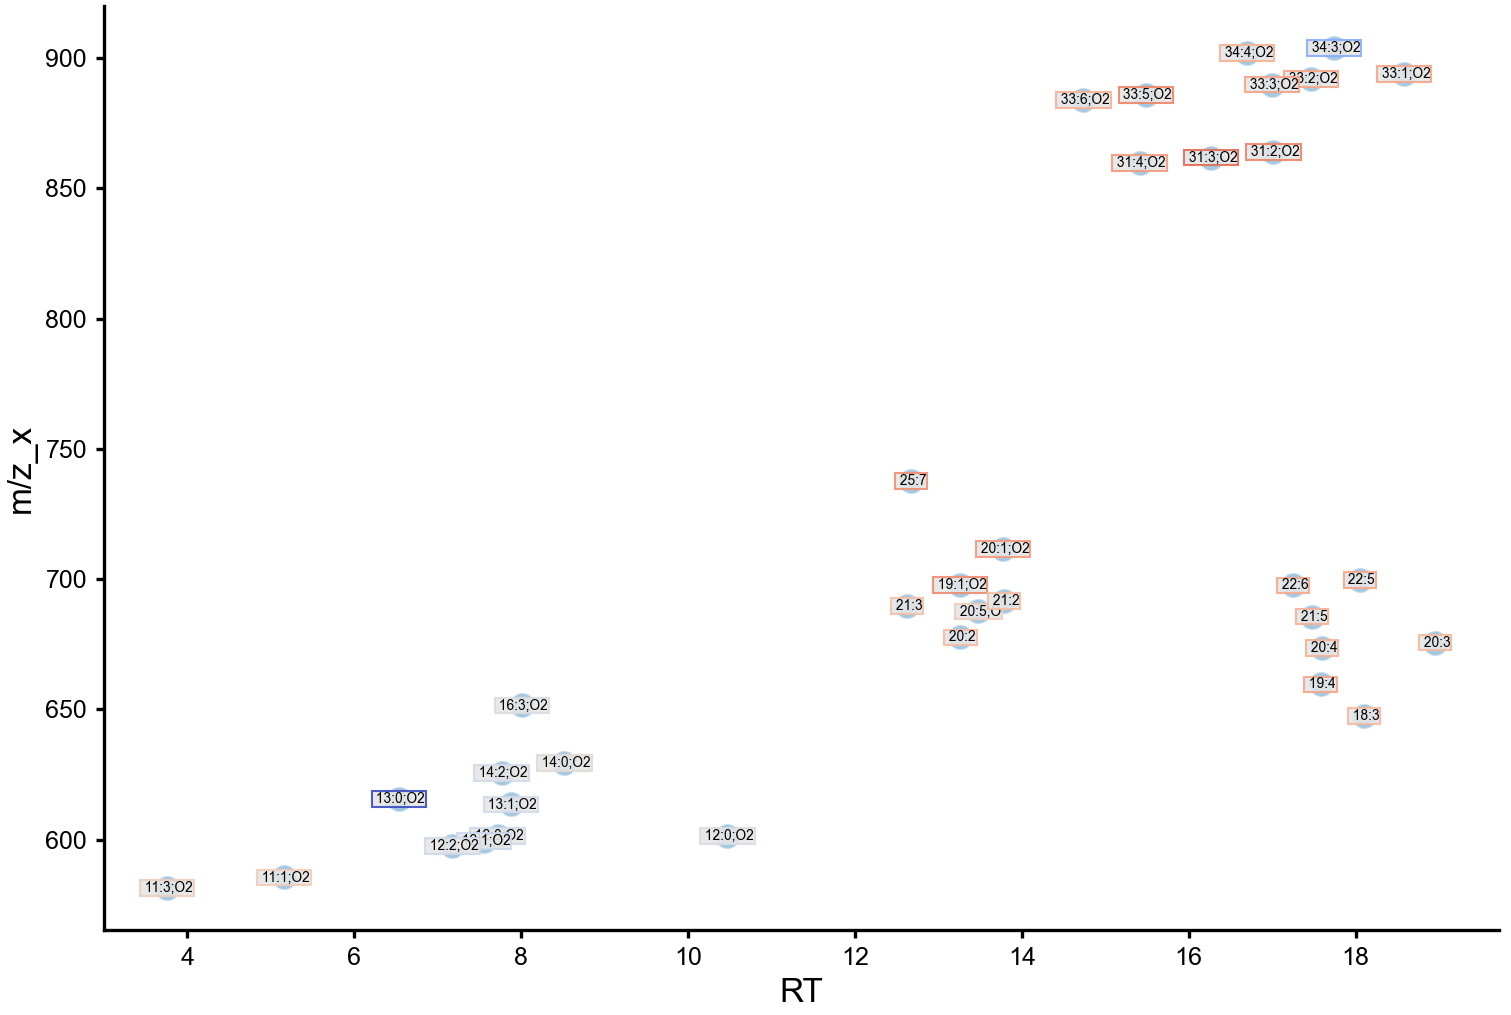

In [204]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
sns.scatterplot(
    data=ce_matches, x='RT', y='m/z_x', 
#     hue='u', palette='viridis', 
    alpha=0.4,
#     size='is_id', sizes={True: 10, False: 5},
#     size='ppm_err', 
)

vmax = ce_matches['ppm_err'].abs().max()
sm = plt.matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=-vmax, vmax=vmax), cmap='coolwarm')
sm.set_array([])
for i, row in ce_matches.iterrows():
#     s = f"{int(row['c'])}:{int(row['u'])}"
    s = row['abbrev'][2:]
    edgecolor = sm.to_rgba(row['ppm_err']) 
    ax.text(row['RT'], row['m/z_x'], s, va='center', ha='center', 
            bbox=dict(lw=0.5, edgecolor=edgecolor, fc='0.9', pad=0.2, alpha=0.9), fontsize=3.3)

ax.legend(loc=(1, 0), fontsize=4)
sns.despine()

# Holy shit look at these CEs
CE 11:1;O2


CE 33:6;O2

# but be mindful of the wide difference in ppm errors

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<Figure size 768x576 with 0 Axes>

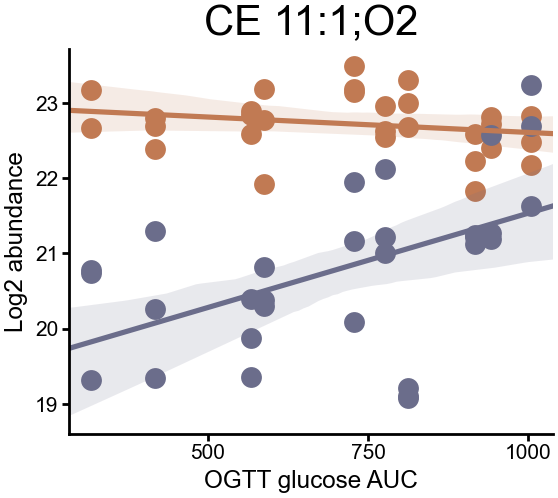

<Figure size 768x576 with 0 Axes>

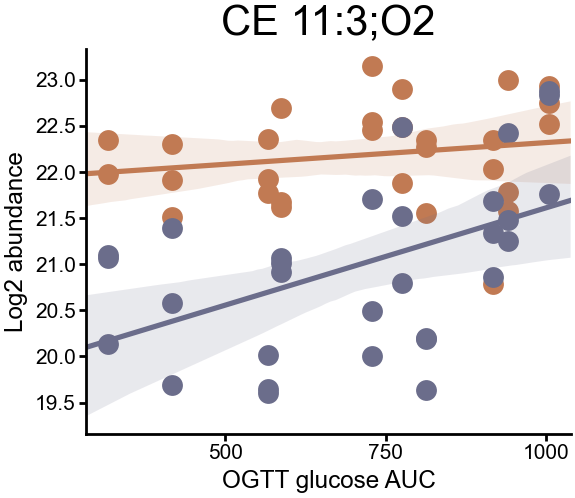

<Figure size 768x576 with 0 Axes>

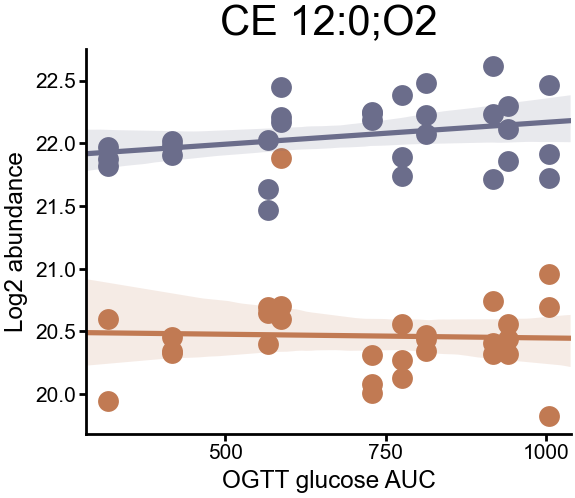

<Figure size 768x576 with 0 Axes>

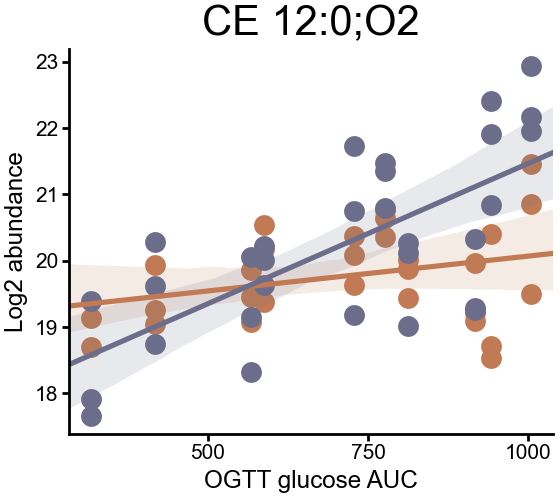

<Figure size 768x576 with 0 Axes>

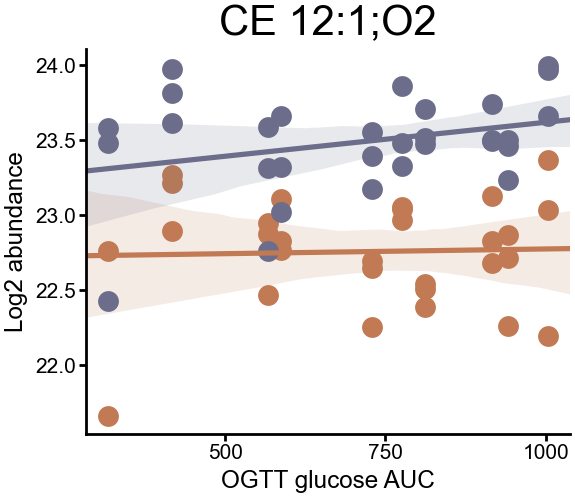

<Figure size 768x576 with 0 Axes>

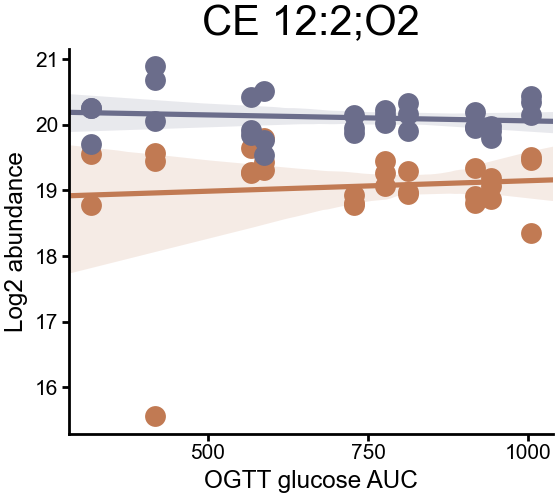

<Figure size 768x576 with 0 Axes>

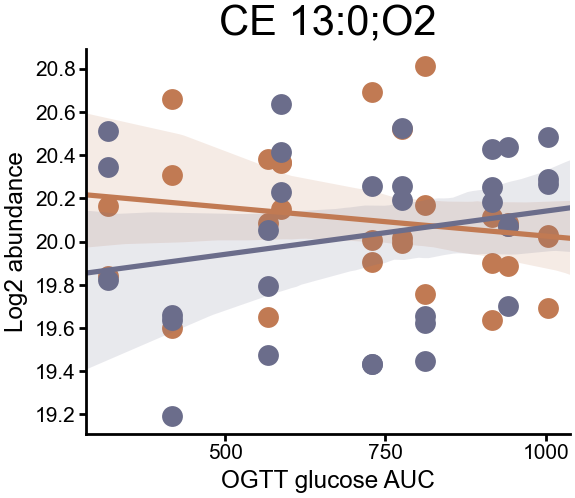

<Figure size 768x576 with 0 Axes>

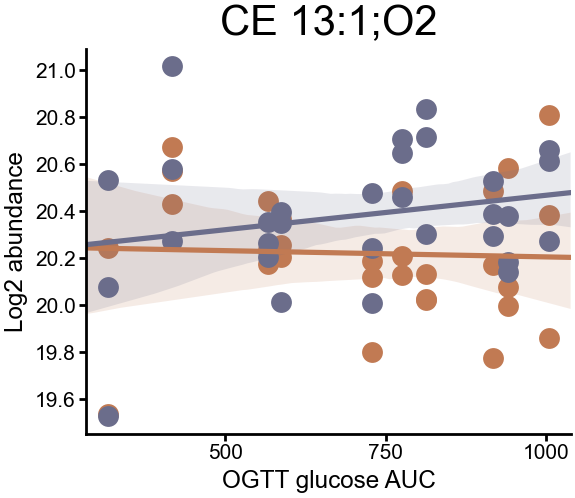

<Figure size 768x576 with 0 Axes>

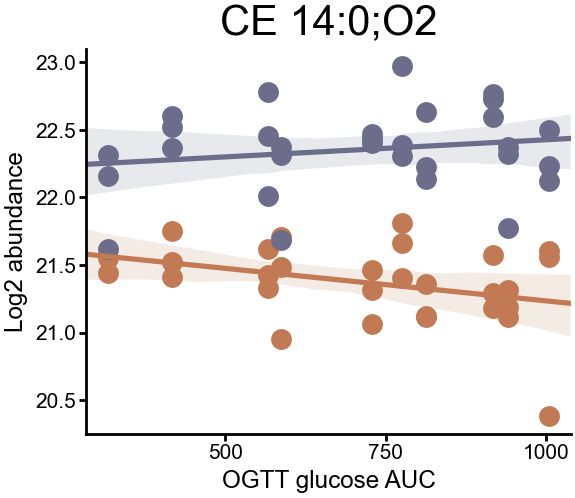

<Figure size 768x576 with 0 Axes>

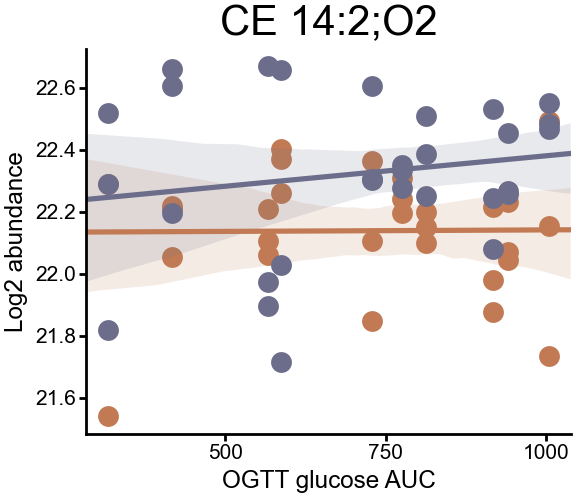

<Figure size 768x576 with 0 Axes>

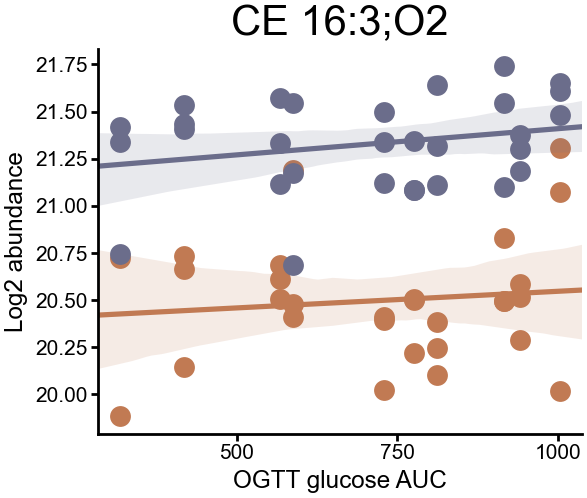

<Figure size 768x576 with 0 Axes>

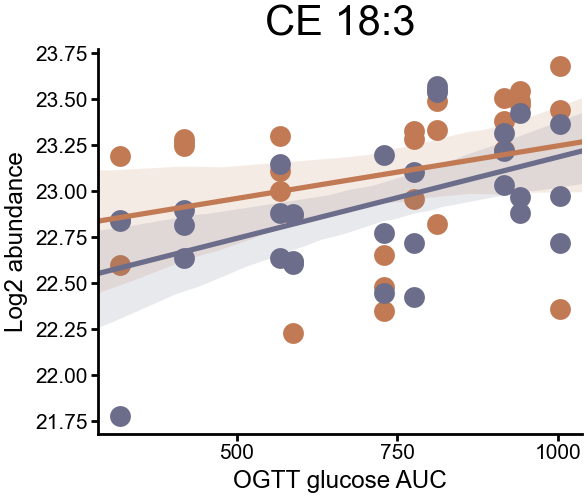

<Figure size 768x576 with 0 Axes>

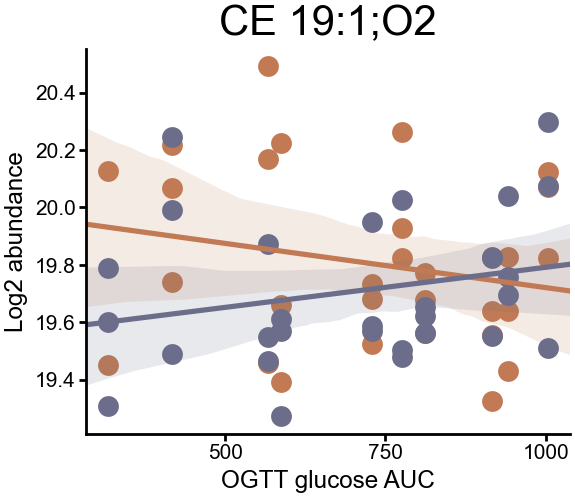

<Figure size 768x576 with 0 Axes>

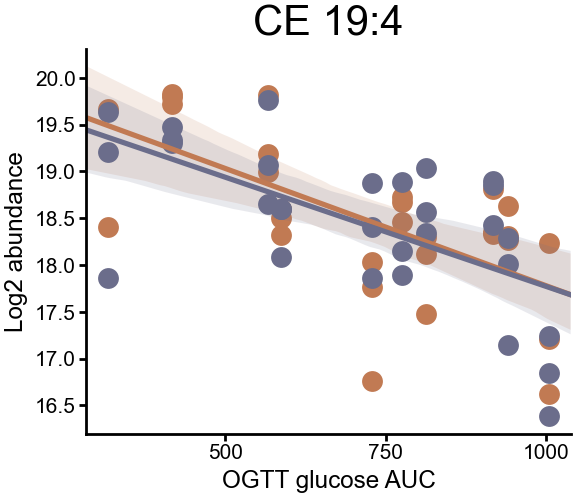

<Figure size 768x576 with 0 Axes>

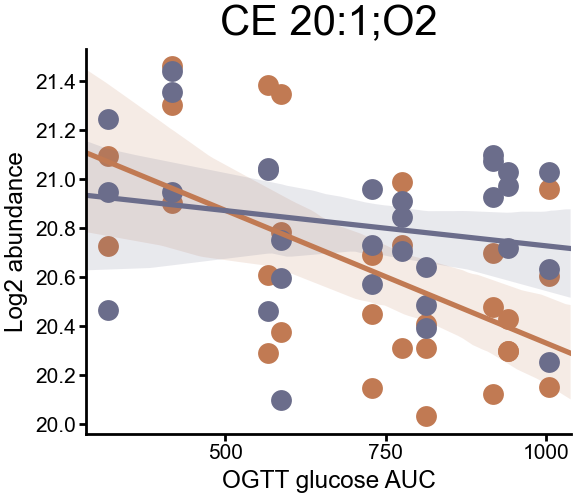

<Figure size 768x576 with 0 Axes>

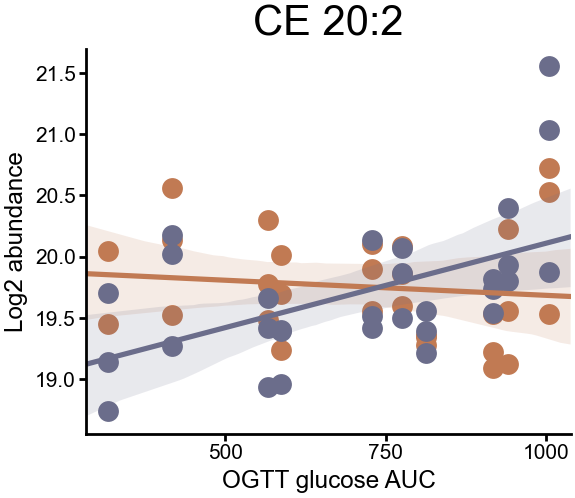

<Figure size 768x576 with 0 Axes>

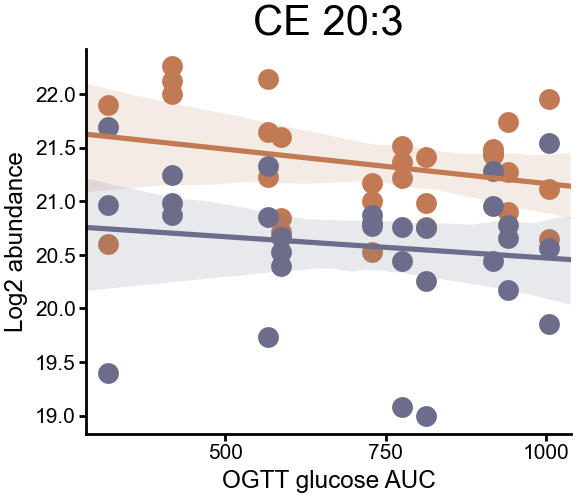

<Figure size 768x576 with 0 Axes>

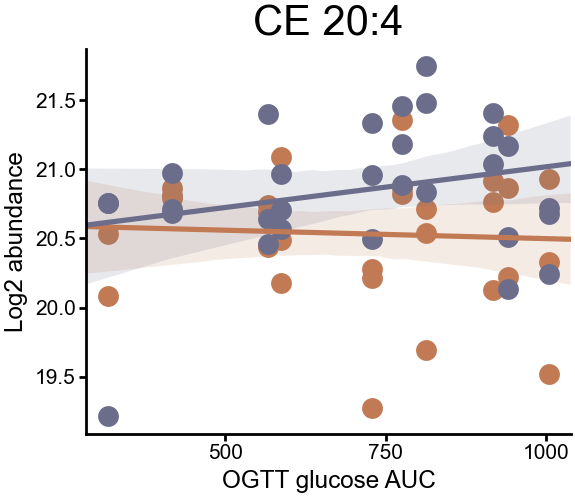

<Figure size 768x576 with 0 Axes>

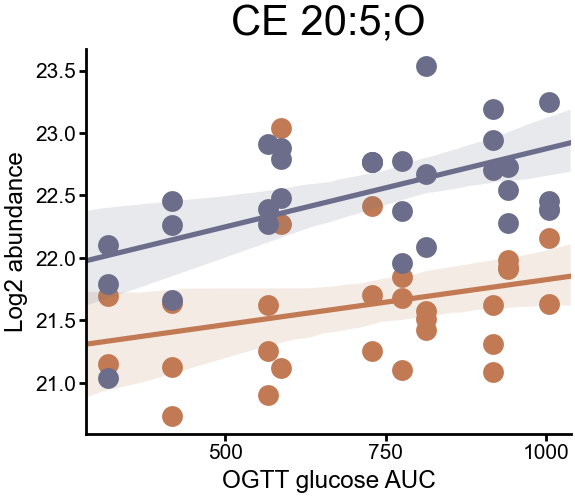

<Figure size 768x576 with 0 Axes>

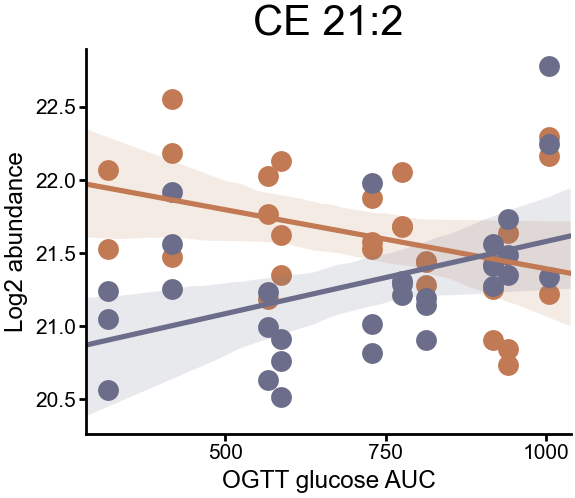

<Figure size 768x576 with 0 Axes>

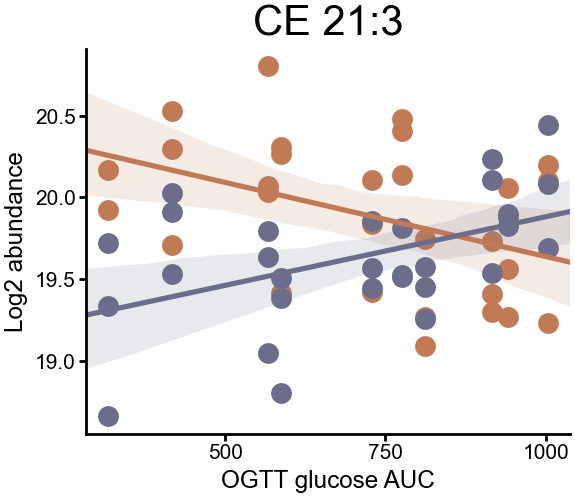

<Figure size 768x576 with 0 Axes>

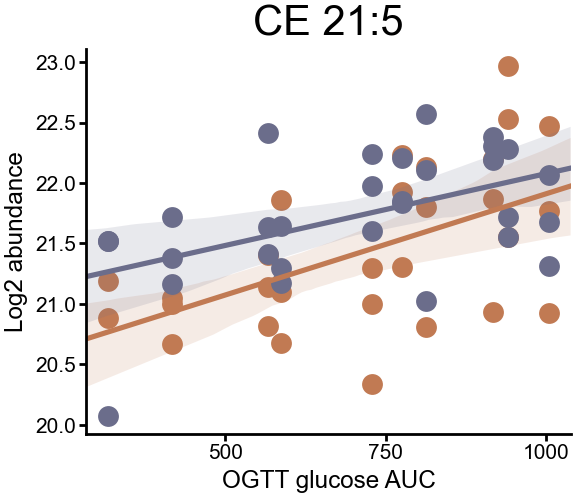

<Figure size 768x576 with 0 Axes>

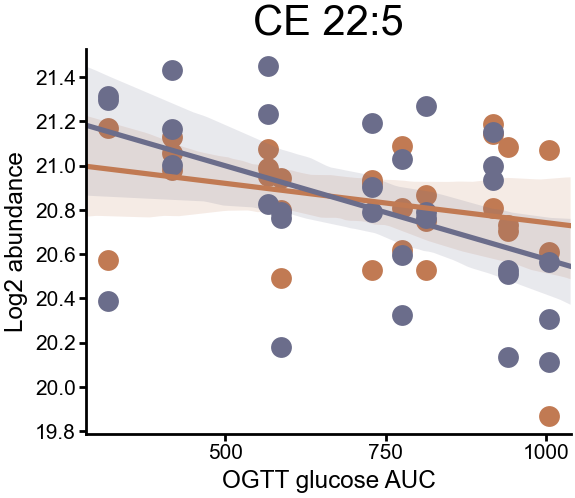

<Figure size 768x576 with 0 Axes>

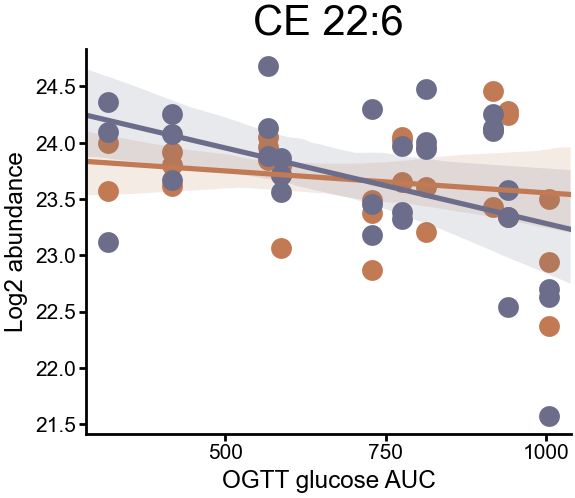

<Figure size 768x576 with 0 Axes>

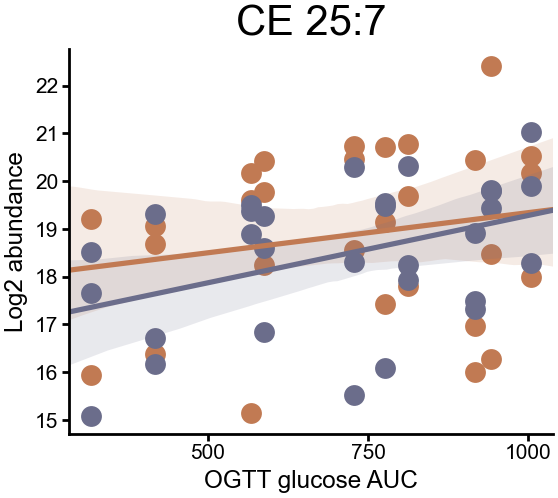

<Figure size 768x576 with 0 Axes>

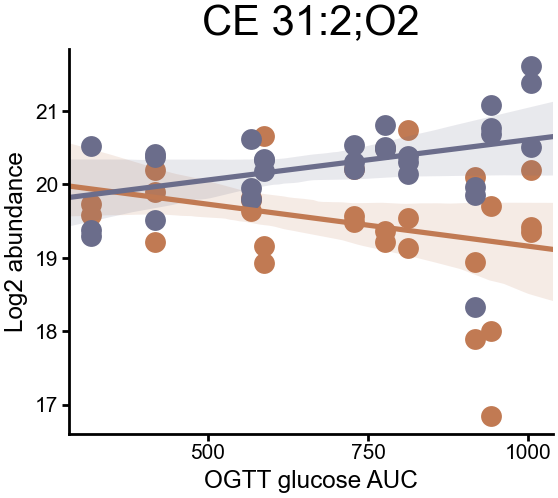

<Figure size 768x576 with 0 Axes>

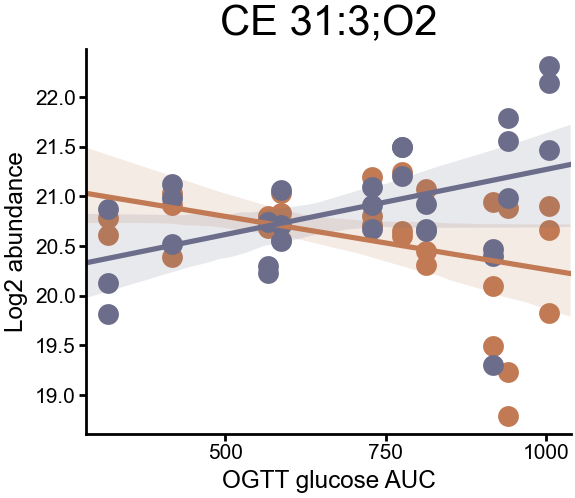

<Figure size 768x576 with 0 Axes>

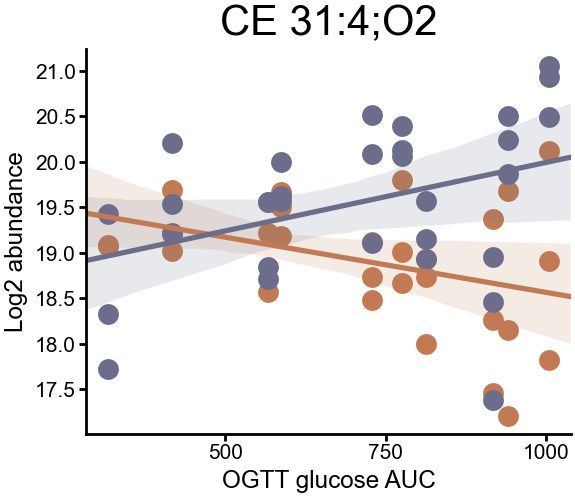

<Figure size 768x576 with 0 Axes>

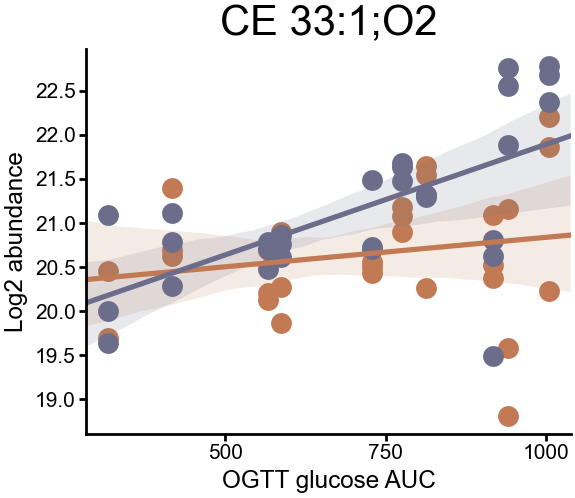

<Figure size 768x576 with 0 Axes>

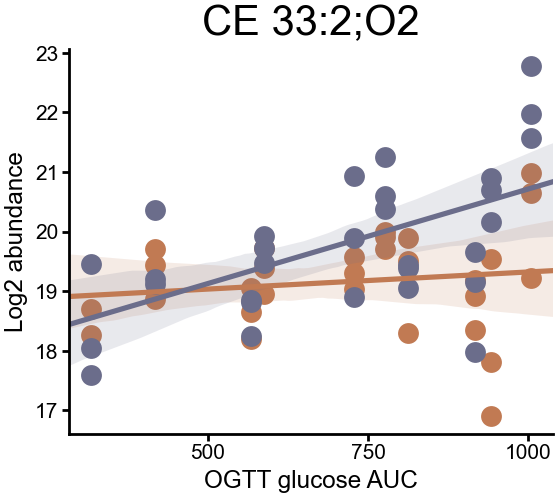

<Figure size 768x576 with 0 Axes>

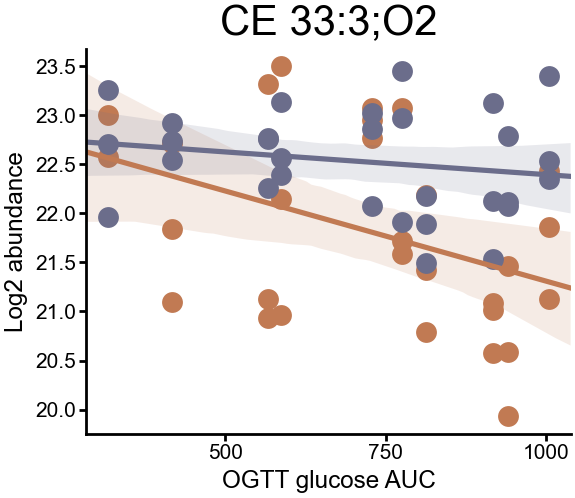

<Figure size 768x576 with 0 Axes>

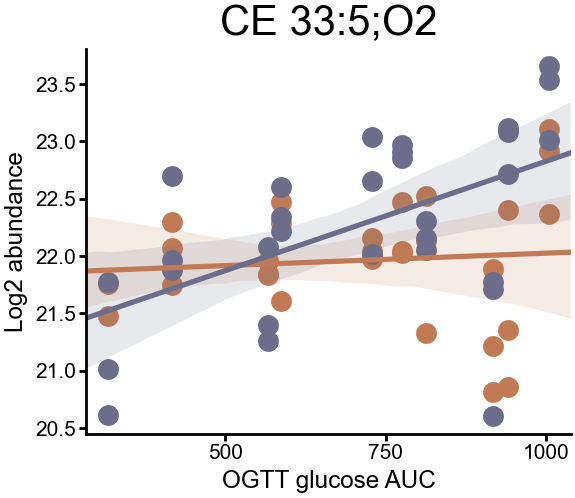

<Figure size 768x576 with 0 Axes>

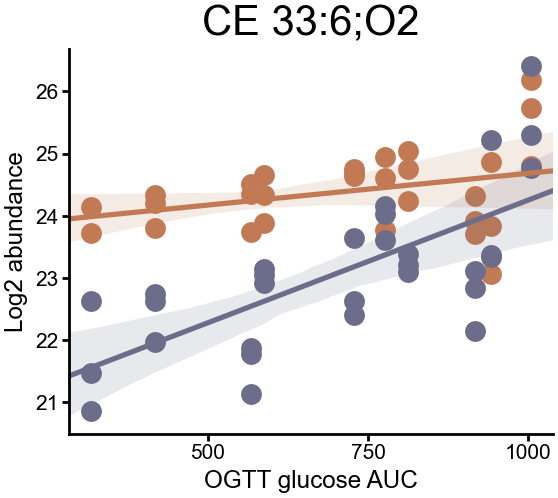

<Figure size 768x576 with 0 Axes>

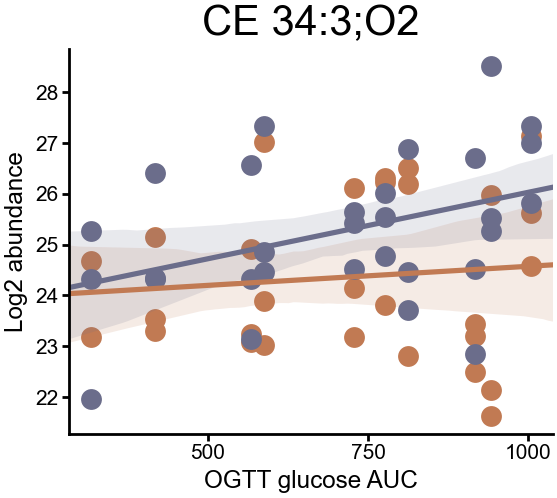

<Figure size 768x576 with 0 Axes>

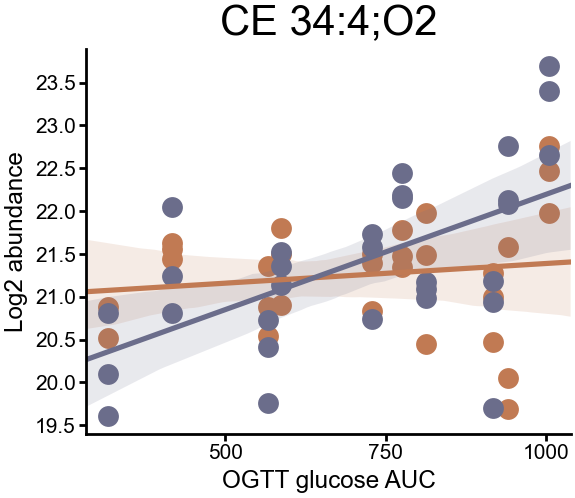

In [205]:
for _, row in ce_matches.iterrows():
    i = row['data_i']
    name = row['abbrev']
    plt.figure()
    src.plots.plot_quant_vs_ogtt(i)
    plt.title(name)

In [233]:
top_signif = data.loc[(data['ID'] == 'Unidentified') & (data['Type'] == 'lipid'), 
                      ['qval_fed', 'qval_fasted', 'ID', 'RT', 'm/z']].sort_values('qval_fed')
top_signif.iloc[:50]

qval_fed  qval_fasted            ID      RT         m/z
i                                                                 
l_581  5.684588e-08     0.000171  Unidentified  13.387  1081.79688
l_717  5.684588e-08     0.000009  Unidentified  16.202   993.72913
l_718  5.757441e-08     0.000285  Unidentified  16.204  1013.82697
l_610  1.674096e-07     0.009222  Unidentified  14.113   994.77686
l_609  2.252057e-07     0.005914  Unidentified  14.113  1033.79663
l_612  2.452549e-07     0.062272  Unidentified  14.116   983.78033
l_693  6.496804e-07     0.002192  Unidentified  15.810   996.80133
l_339  7.016108e-07     0.463478  Unidentified   9.110   554.51630
l_341  7.016108e-07     0.123207  Unidentified   9.164   682.54065
l_624  7.016108e-07     0.007604  Unidentified  14.489   985.79382
l_604  1.218430e-06     0.679212  Unidentified  13.830   957.76660
l_602  1.218430e-06     0.393176  Unidentified  13.829   968.76172
l_535  1.263145e-06     0.422519  Unidentified  12.065   664.62573
l_649  1.390954e-06     0.059930  Unidentified  14.917  1035.81213
l_622  1.390954e-06     0.003090  Unidentified  14.487  1035.81213
l_385  1.390954e-06     0.111375  Unidentified   9.496  1032.61377
l_812  1.390954e-06     0.003975  Unidentified  17.480   383.36713
l_661  1.611851e-06     0.011835  Unidentified  15.275   996.80164
l_583  2.249359e-06     0.037477  Unidentified  13.394   990.75452
l_359  2.249359e-06     0.088046  Unidentified   9.240  1606.17834
l_573  2.890600e-06     0.954648  Unidentified  13.211   666.64185
l_743  2.905520e-06     0.008004  Unidentified  16.528   974.81665
l_645  2.966223e-06     0.013805  Unidentified  14.854   985.79657
l_568  3.350052e-06     0.375289  Unidentified  13.063   941.72107
l_543  3.375226e-06     0.538308  Unidentified  12.155   674.58691
l_560  3.493031e-06     0.811689  Unidentified  12.677   652.62622
l_601  3.493389e-06     0.782141  Unidentified  13.823  1007.78046
l_158  3.504425e-06     0.358704  Unidentified   7.481   635.45380
l_657  3.527861e-06     0.097929  Unidentified  15.210   932.76953
l_742  3.544971e-06     0.043399  Unidentified  16.498   969.73041
l_695  3.969762e-06     0.808204  Unidentified  15.818   913.72266
l_614  3.998162e-06     0.020905  Unidentified  14.220  1009.79669
l_589  4.510821e-06     0.070711  Unidentified  13.499   990.75446
l_688  4.510821e-06     0.102039  Unidentified  15.642   961.79651
l_682  4.510821e-06     0.028419  Unidentified  15.620   987.81250
l_650  5.147186e-06     0.067271  Unidentified  14.927   982.78235
l_585  5.927047e-06     0.057058  Unidentified  13.429   941.72095
l_796  7.000330e-06     0.048934  Unidentified  17.220   991.84320
l_643  7.395047e-06     0.007760  Unidentified  14.850   935.78052
l_563  7.518836e-06     0.422519  Unidentified  12.798   988.73981
l_752  8.102873e-06     0.008571  Unidentified  16.644   976.83118
l_625  9.433126e-06     0.063528  Unidentified  14.510   944.77051
l_35   9.546748e-06     0.420425  Unidentified   1.530   642.36377
l_390  9.546748e-06     0.149149  Unidentified   9.503   950.61182
l_620  1.002009e-05     0.163905  Unidentified  14.468   907.74701
l_588  1.040073e-05     0.046333  Unidentified  13.497  1031.78162
l_420  1.057878e-05     0.207151  Unidentified   9.882   684.55664
l_423  1.309467e-05     0.537795  Unidentified   9.908  1620.19287
l_801  1.456458e-05     0.002924  Unidentified  17.360   978.84882
l_565  1.456458e-05     0.268259  Unidentified  12.808   951.77692

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


<Figure size 768x576 with 0 Axes>

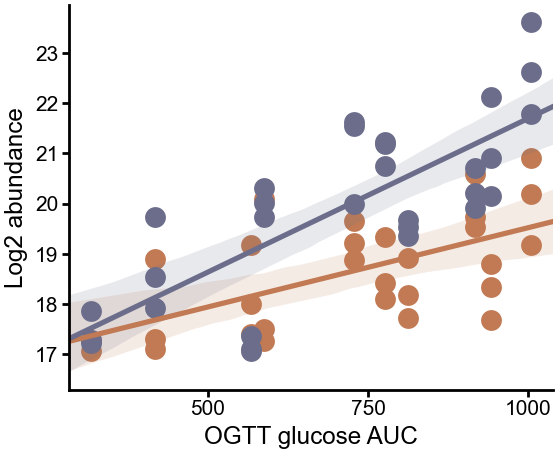

<Figure size 768x576 with 0 Axes>

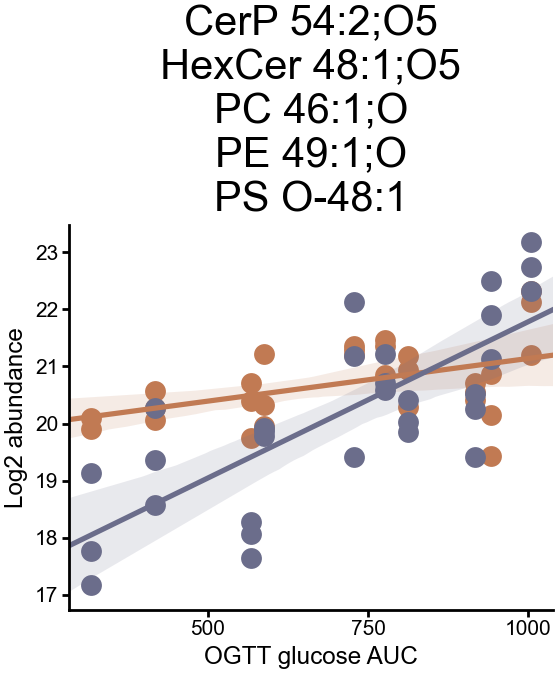

<Figure size 768x576 with 0 Axes>

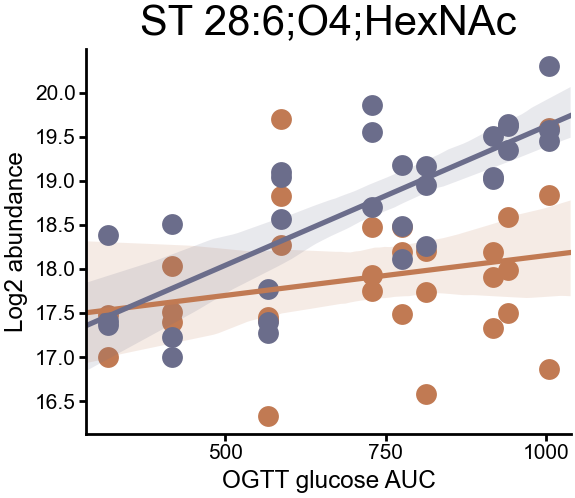

<Figure size 768x576 with 0 Axes>

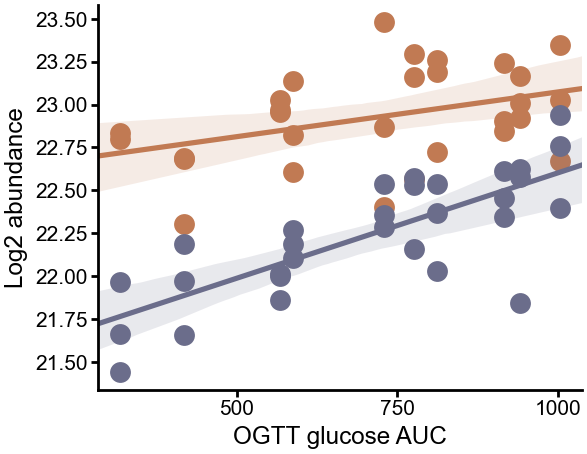

<Figure size 768x576 with 0 Axes>

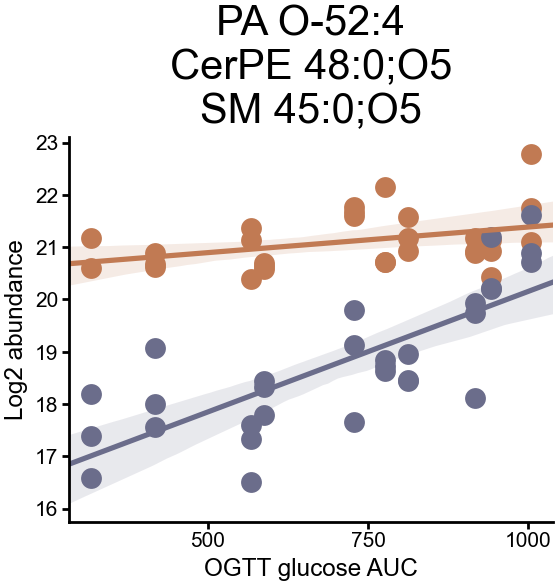

<Figure size 768x576 with 0 Axes>

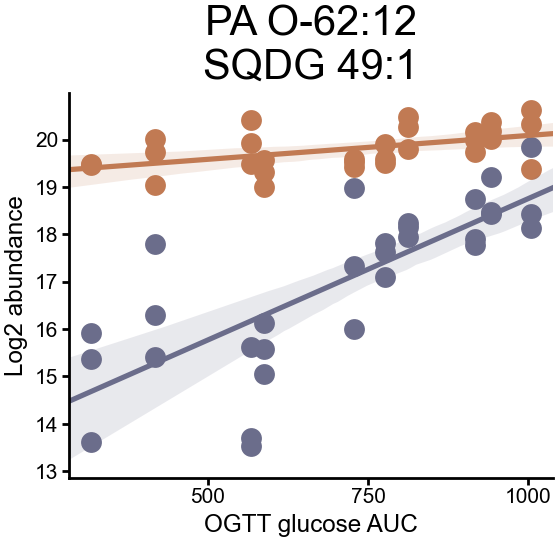

<Figure size 768x576 with 0 Axes>

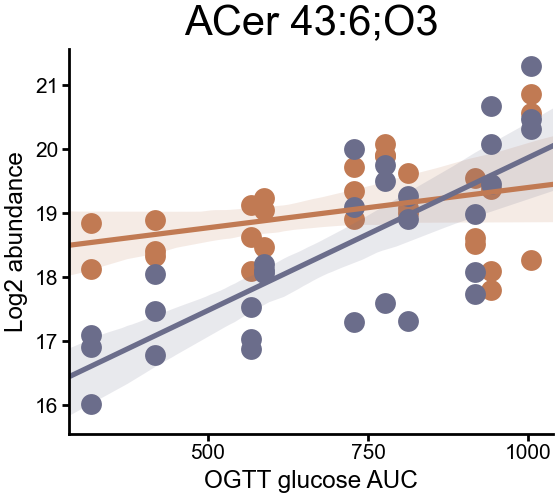

<Figure size 768x576 with 0 Axes>

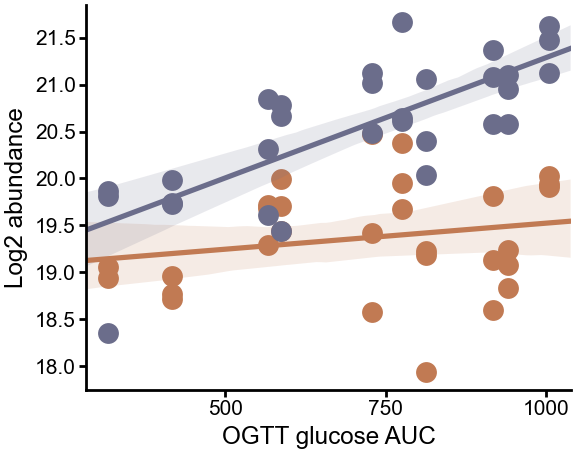

<Figure size 768x576 with 0 Axes>

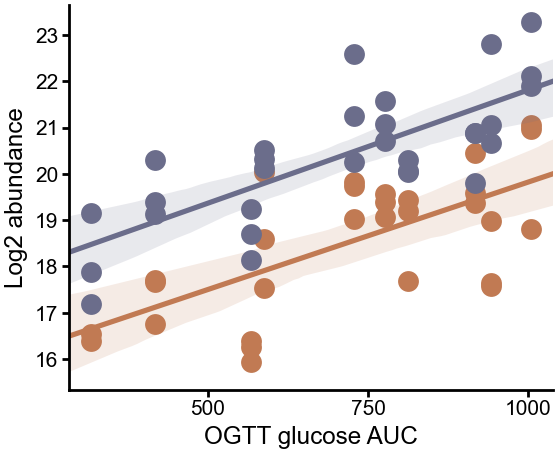

<Figure size 768x576 with 0 Axes>

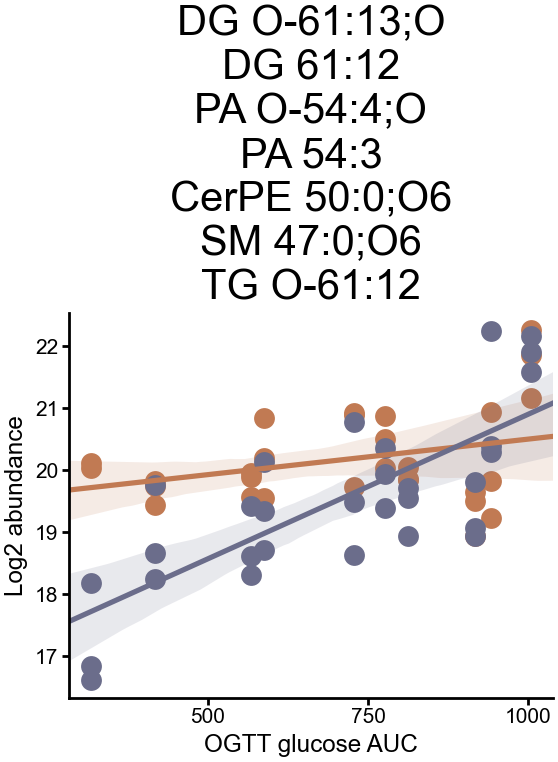

<Figure size 768x576 with 0 Axes>

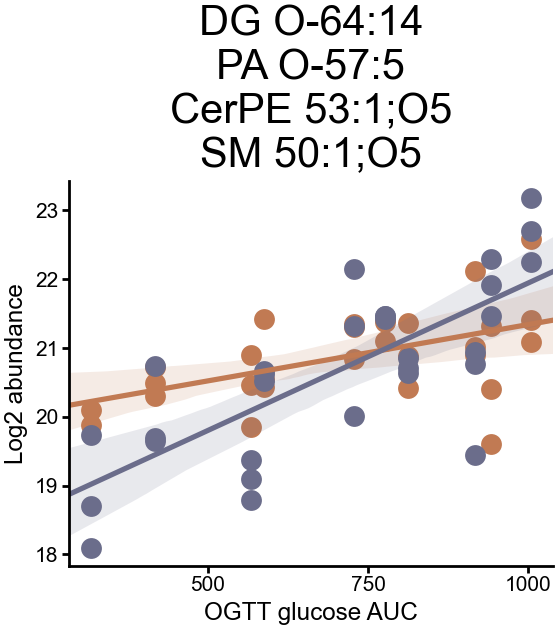

<Figure size 768x576 with 0 Axes>

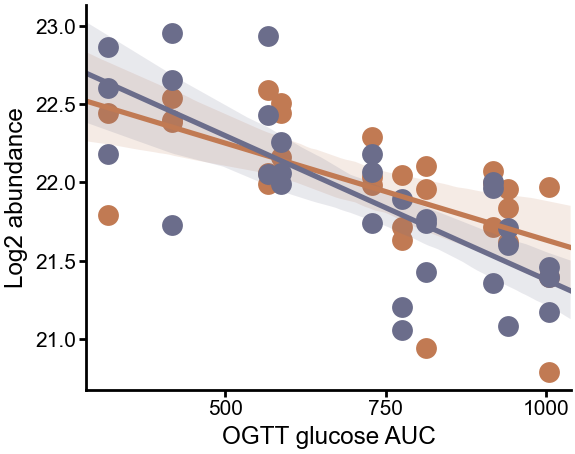

<Figure size 768x576 with 0 Axes>

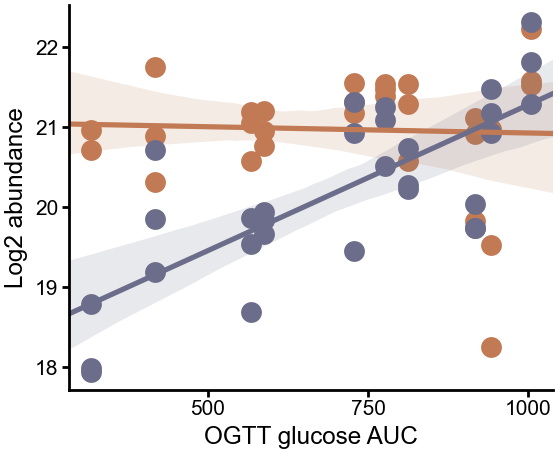

<Figure size 768x576 with 0 Axes>

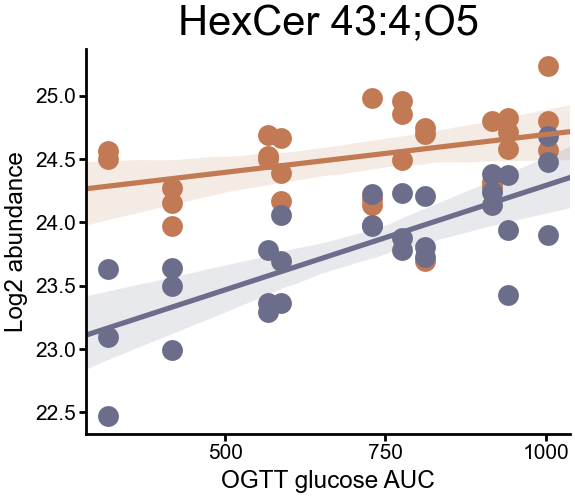

<Figure size 768x576 with 0 Axes>

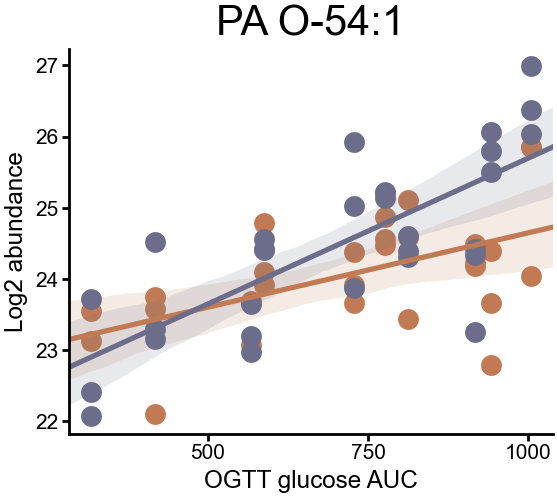

<Figure size 768x576 with 0 Axes>

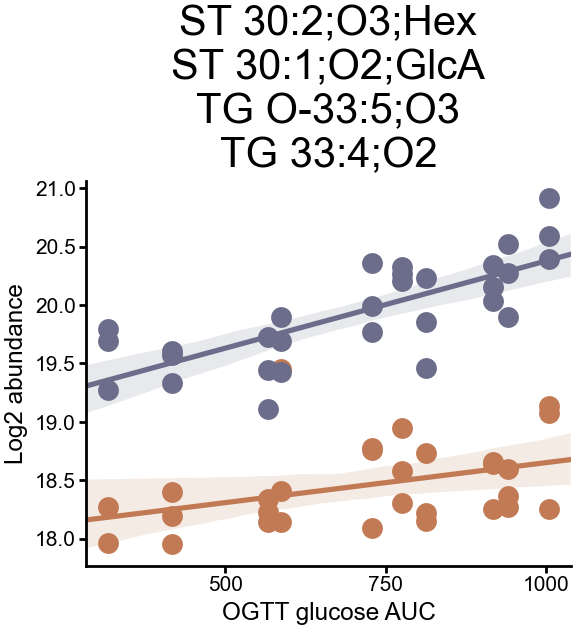

<Figure size 768x576 with 0 Axes>

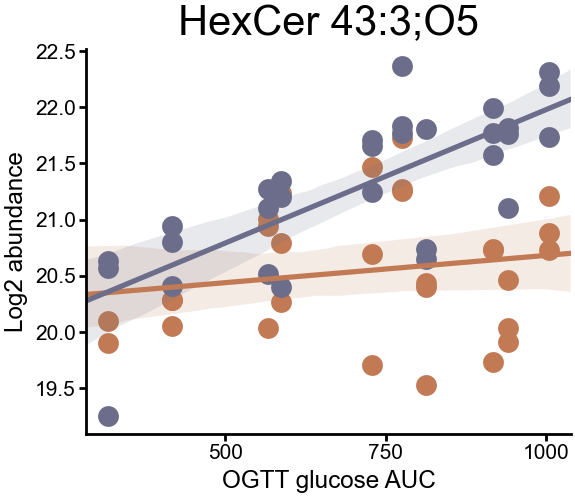

<Figure size 768x576 with 0 Axes>

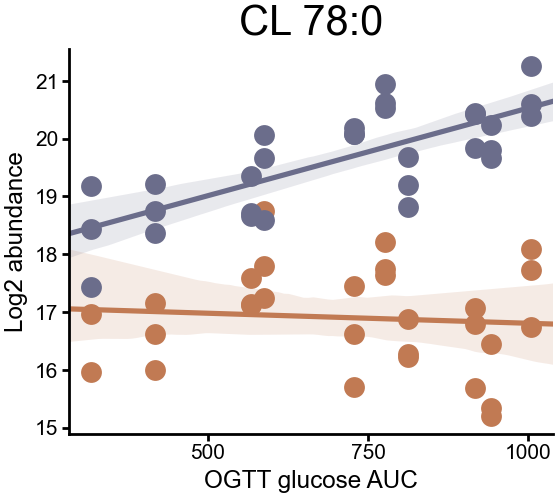

<Figure size 768x576 with 0 Axes>

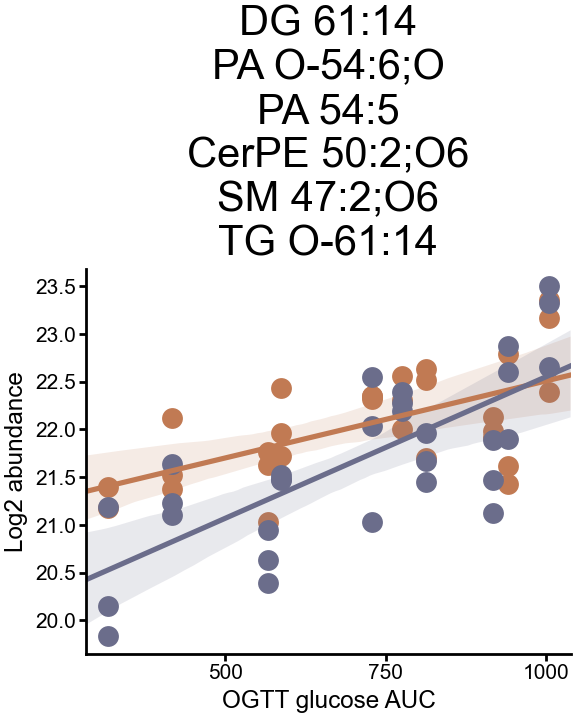

<Figure size 768x576 with 0 Axes>

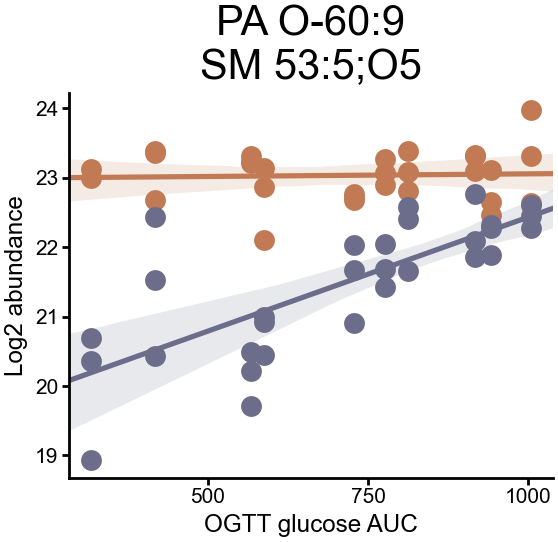

In [235]:
hplus_adducts = ldb['mass'] + H_mass
hmin_adducts = ldb['mass'] - H_mass

closes = []

for i, row in top_signif.iloc[40:60].iterrows():
    close_array = np.isclose(row['m/z'], hplus_adducts, rtol=6e-6, atol=0)
    
    ldb.loc[close_array]
    
    close = ldb.loc[close_array, 'abbrev']
    closes.append(close)
    plt.figure()
    src.plots.plot_quant_vs_ogtt(i)
    plt.title('\n'.join(close))

In [229]:
closes[1]

45127    SQDG 53:4
Name: abbrev, dtype: object

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 768x576 with 0 Axes>

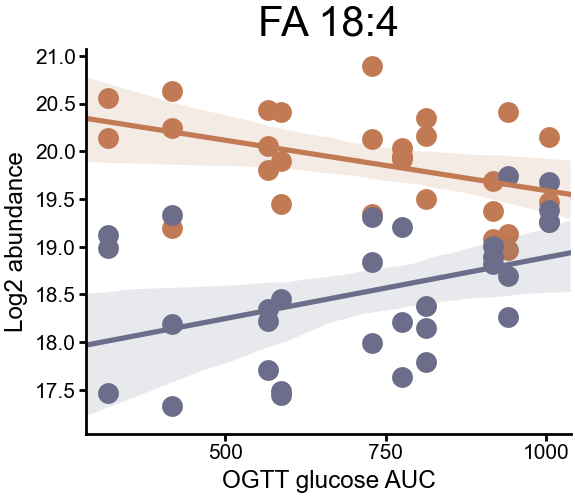

<Figure size 768x576 with 0 Axes>

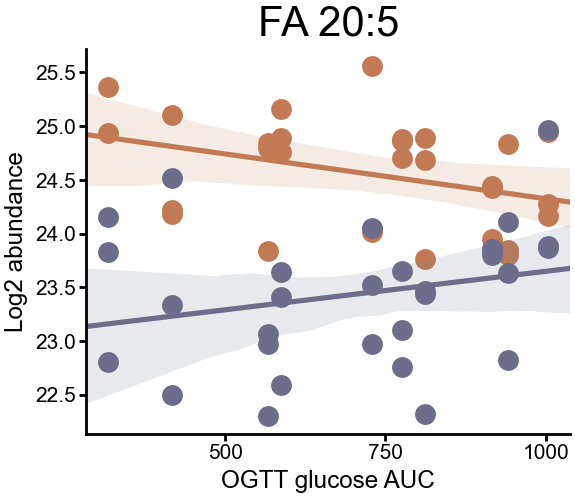

<Figure size 768x576 with 0 Axes>

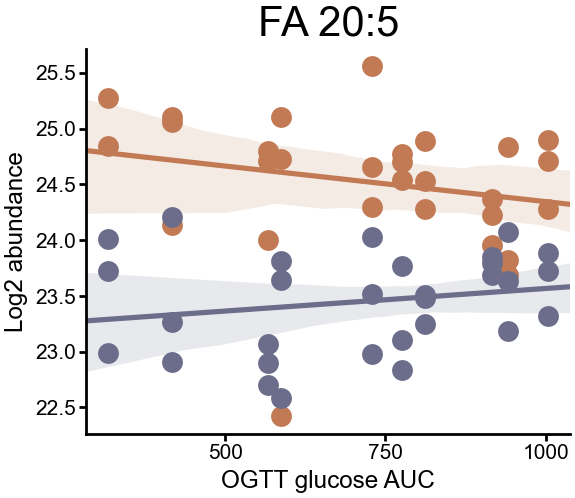

<Figure size 768x576 with 0 Axes>

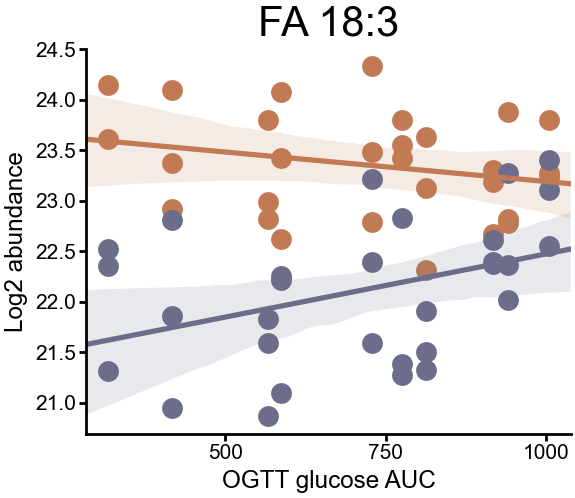

<Figure size 768x576 with 0 Axes>

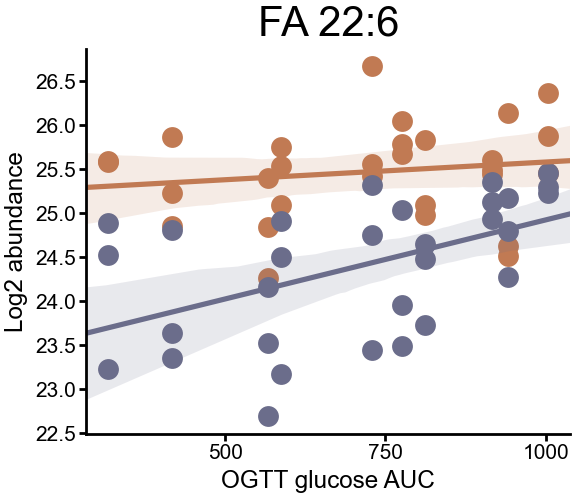

<Figure size 768x576 with 0 Axes>

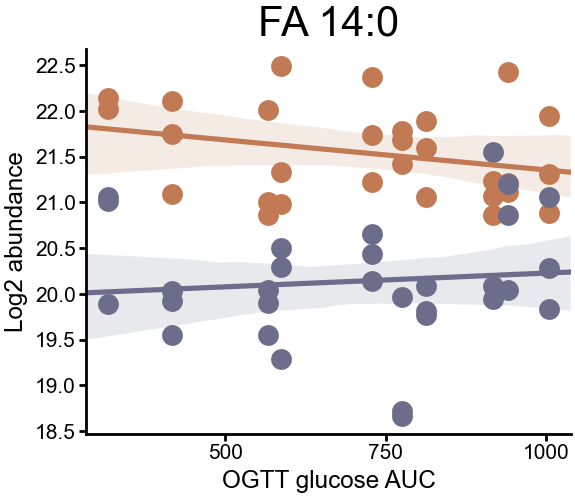

<Figure size 768x576 with 0 Axes>

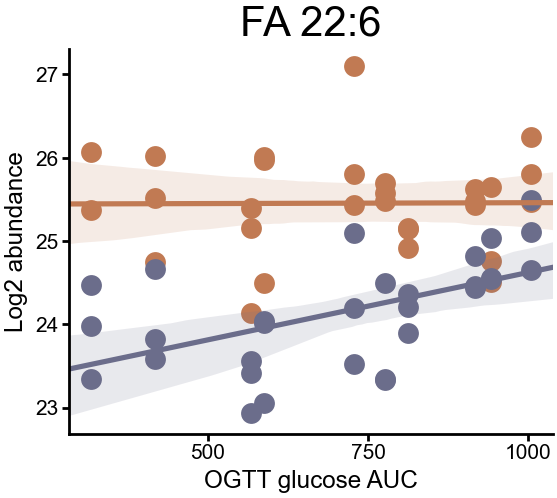

<Figure size 768x576 with 0 Axes>

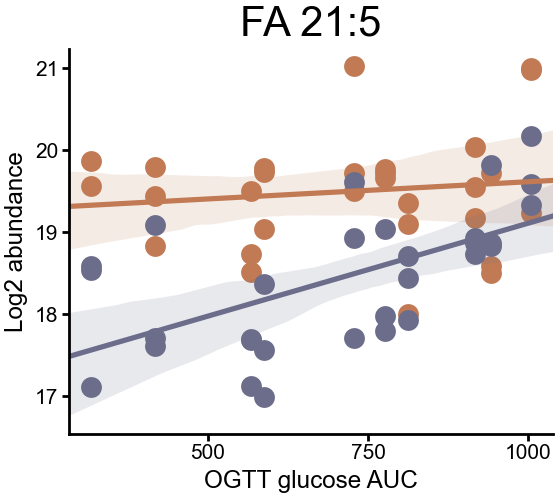

<Figure size 768x576 with 0 Axes>

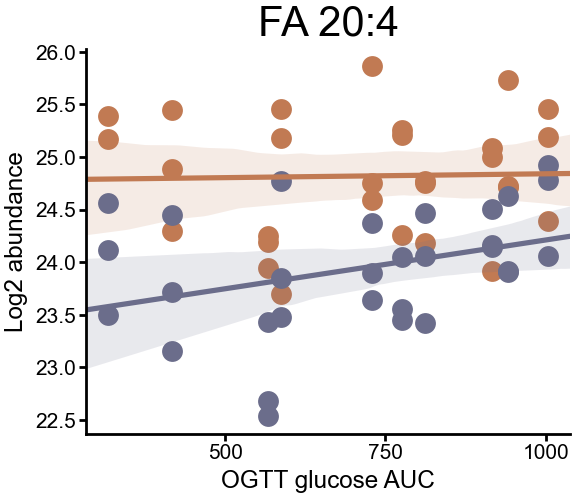

<Figure size 768x576 with 0 Axes>

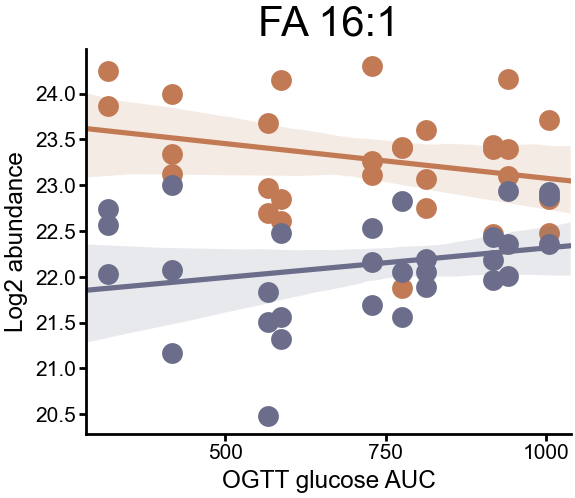

<Figure size 768x576 with 0 Axes>

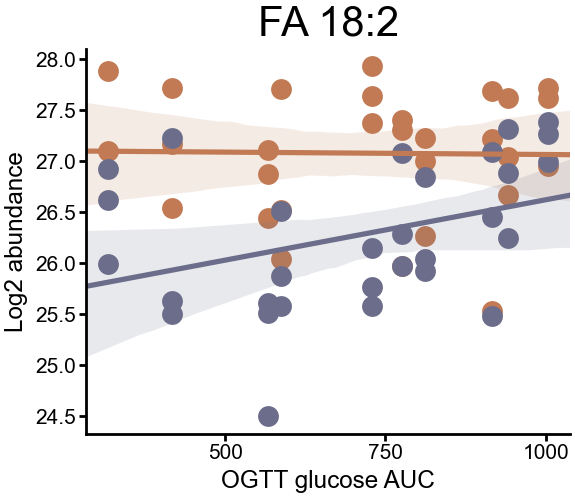

<Figure size 768x576 with 0 Axes>

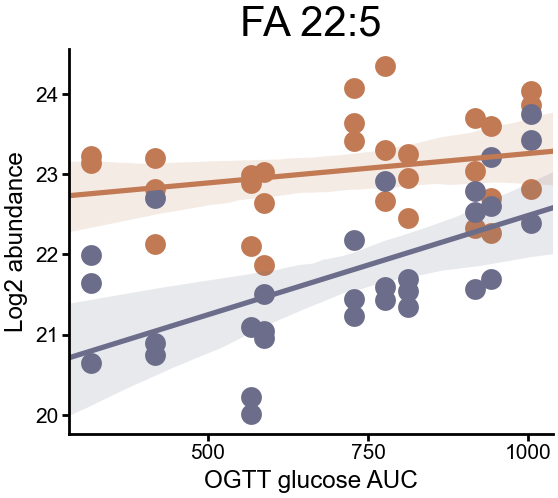

<Figure size 768x576 with 0 Axes>

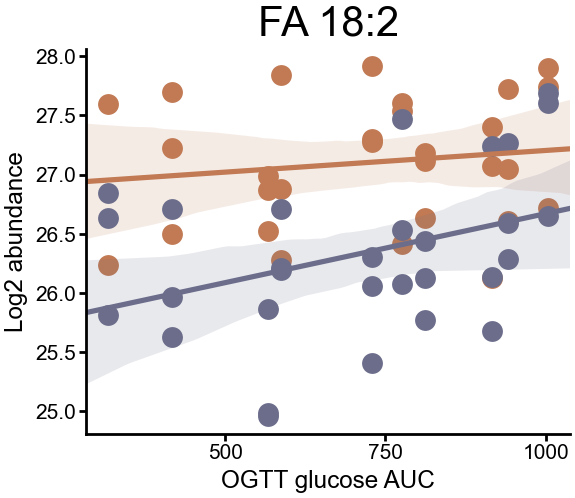

<Figure size 768x576 with 0 Axes>

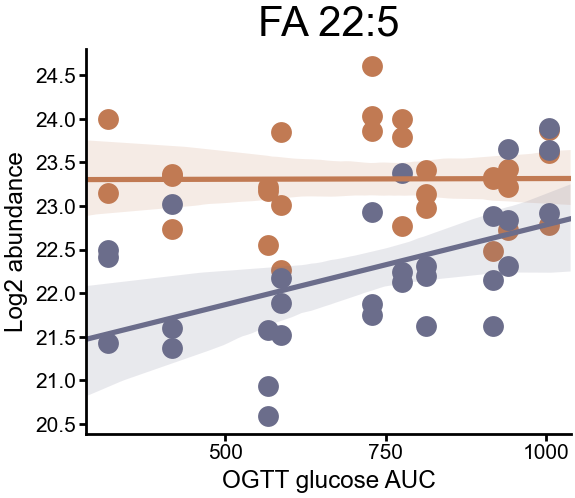

<Figure size 768x576 with 0 Axes>

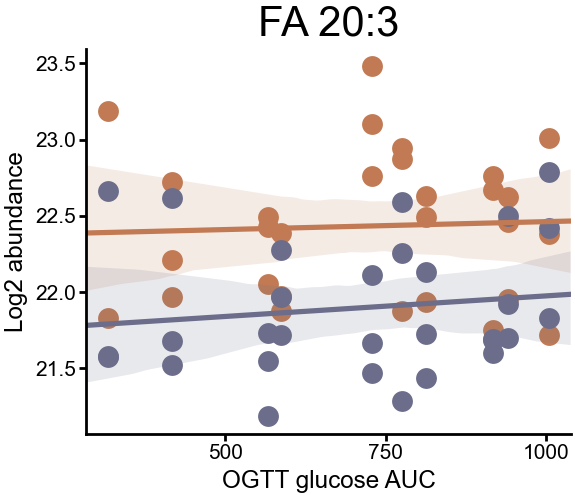

<Figure size 768x576 with 0 Axes>

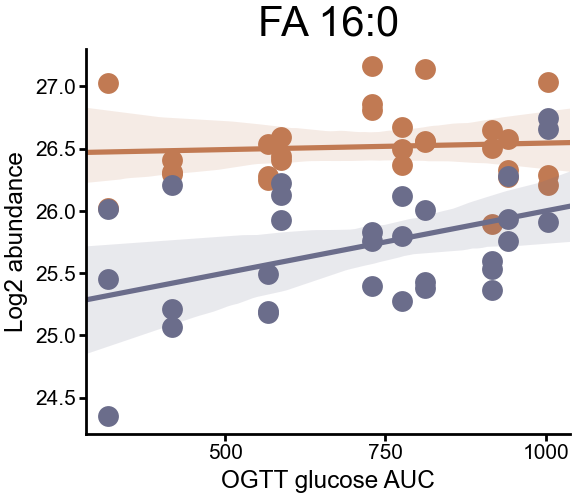

<Figure size 768x576 with 0 Axes>

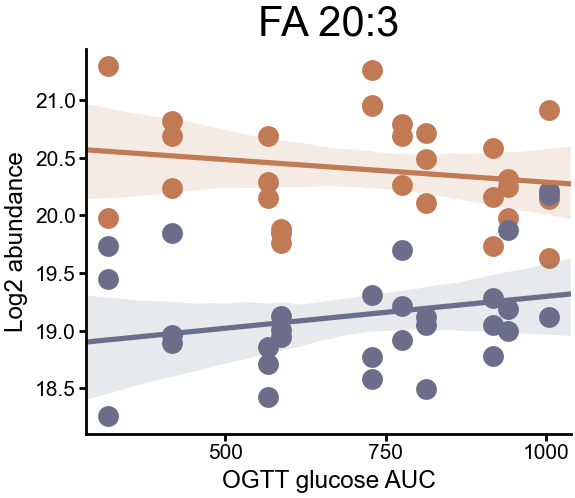

<Figure size 768x576 with 0 Axes>

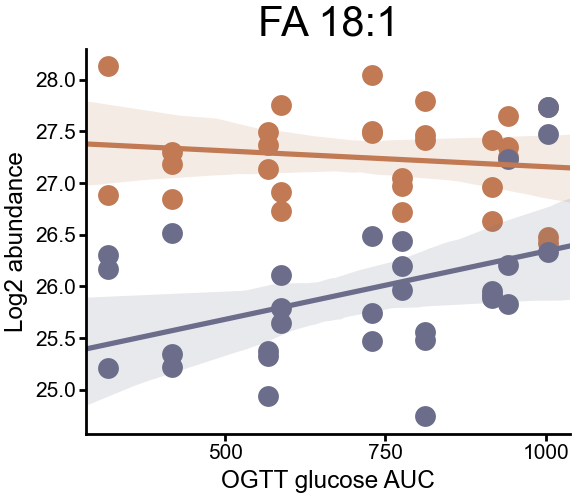

<Figure size 768x576 with 0 Axes>

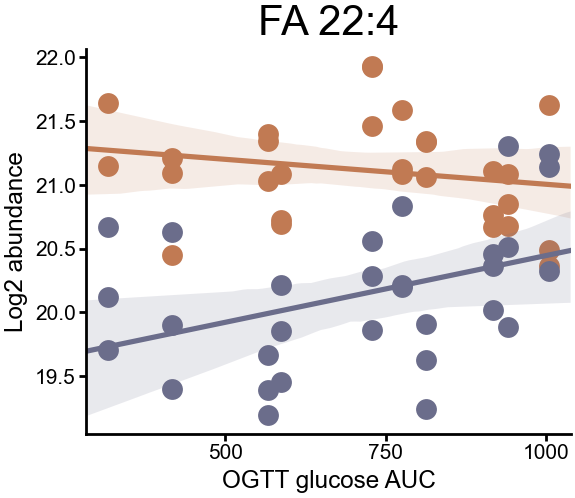

<Figure size 768x576 with 0 Axes>

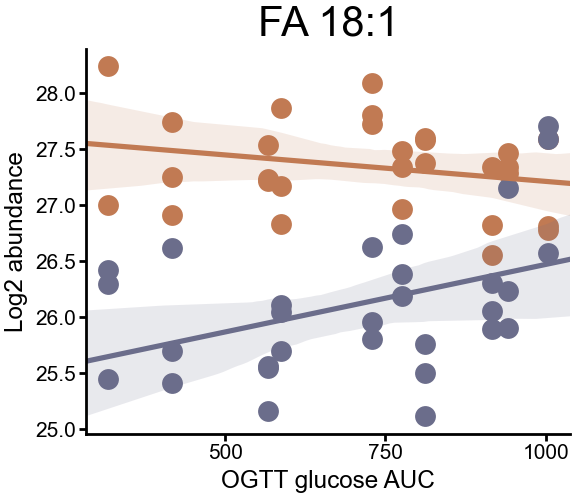

<Figure size 768x576 with 0 Axes>

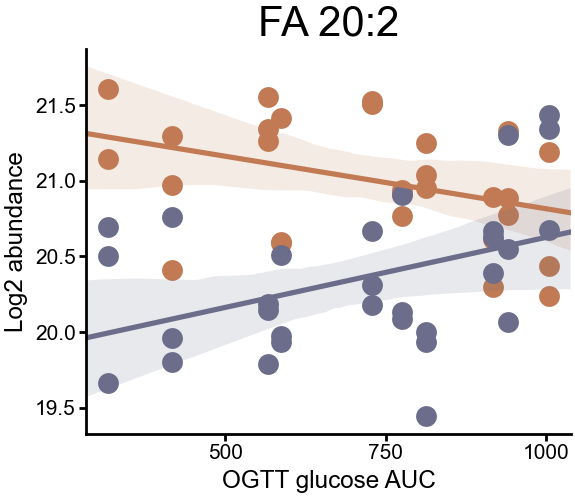

<Figure size 768x576 with 0 Axes>

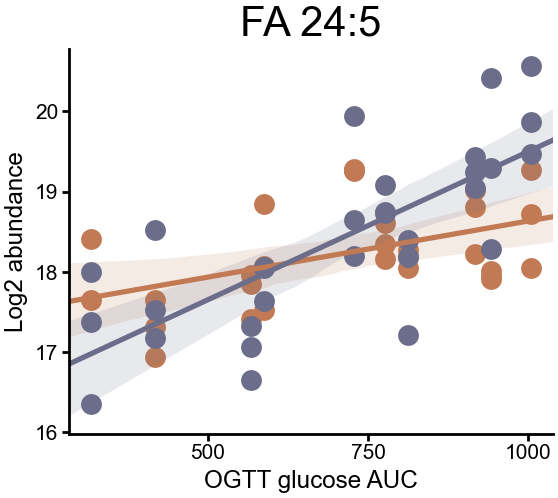

<Figure size 768x576 with 0 Axes>

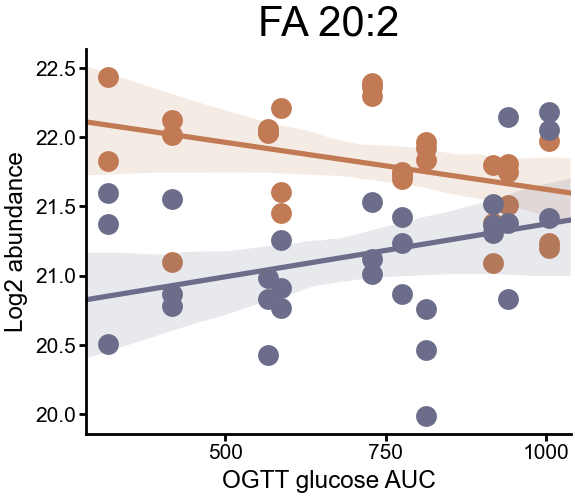

<Figure size 768x576 with 0 Axes>

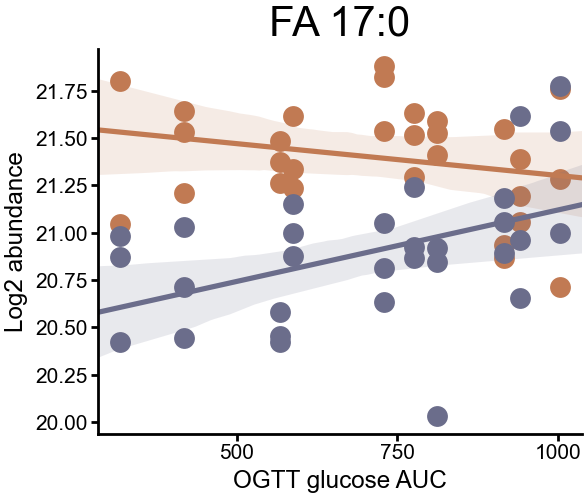

<Figure size 768x576 with 0 Axes>

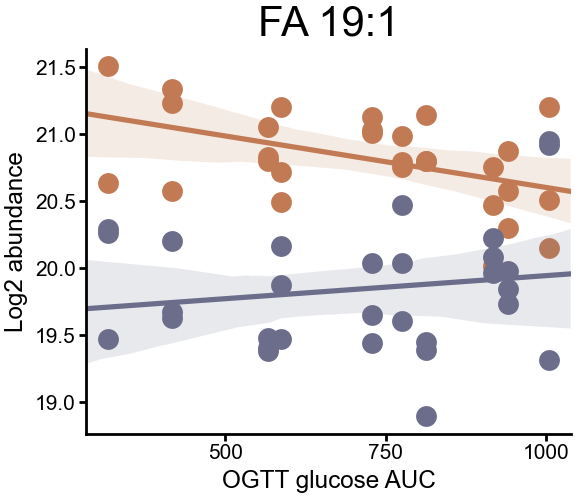

<Figure size 768x576 with 0 Axes>

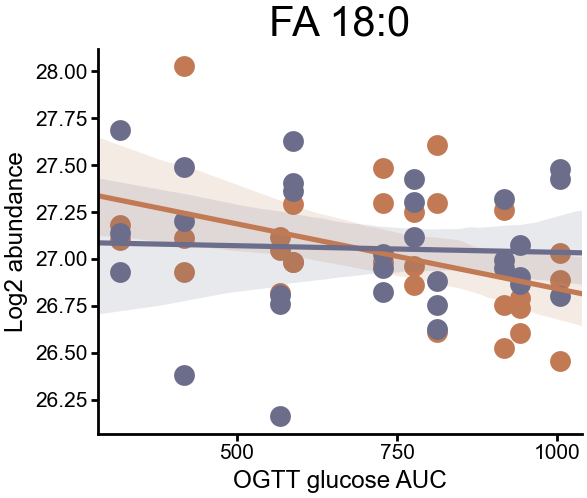

<Figure size 768x576 with 0 Axes>

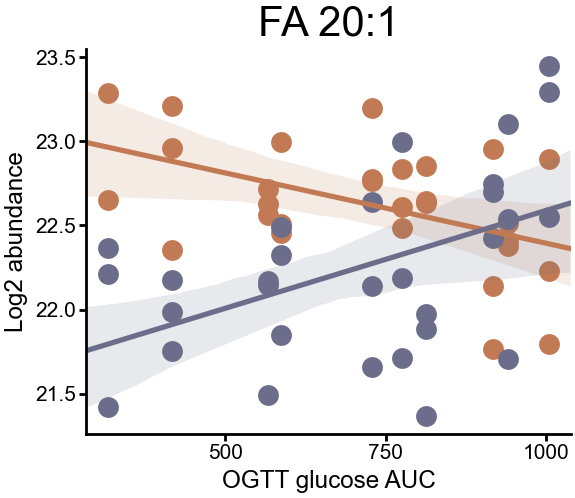

<Figure size 768x576 with 0 Axes>

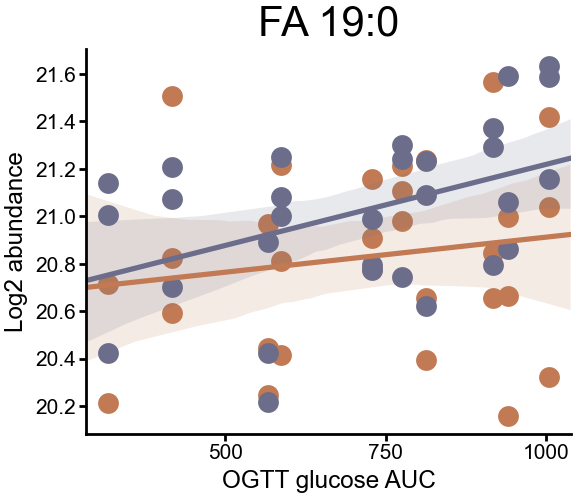

<Figure size 768x576 with 0 Axes>

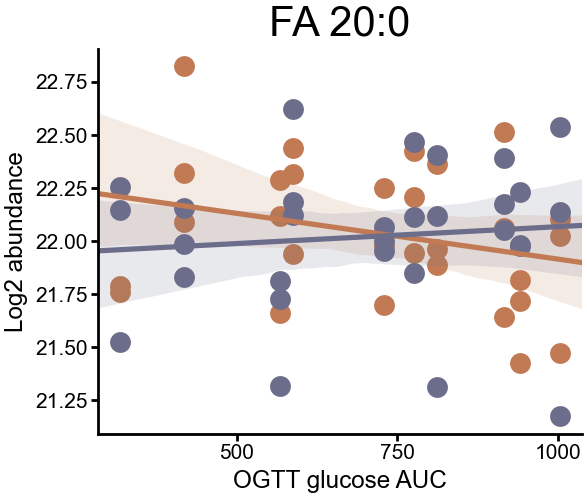

<Figure size 768x576 with 0 Axes>

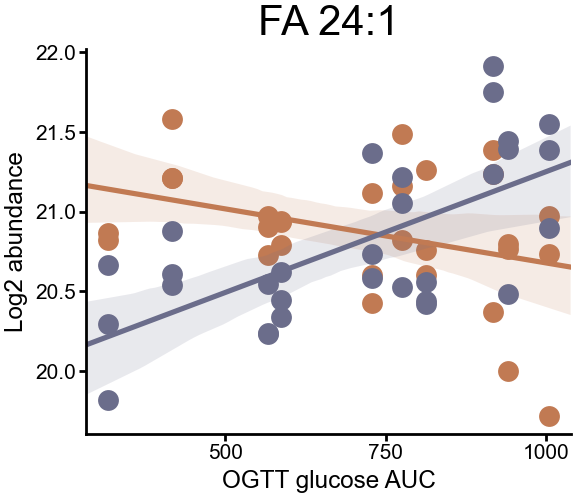

<Figure size 768x576 with 0 Axes>

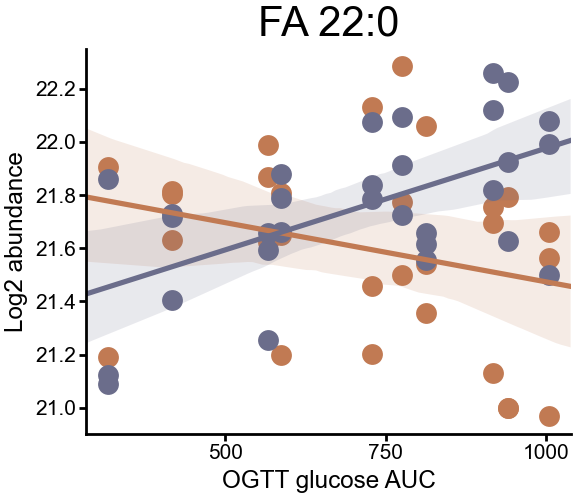

<Figure size 768x576 with 0 Axes>

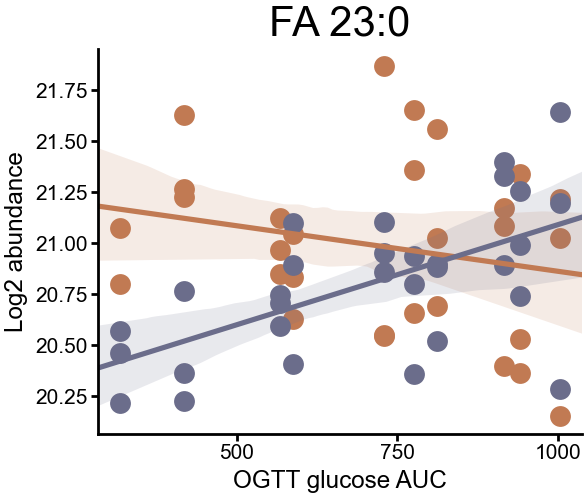

<Figure size 768x576 with 0 Axes>

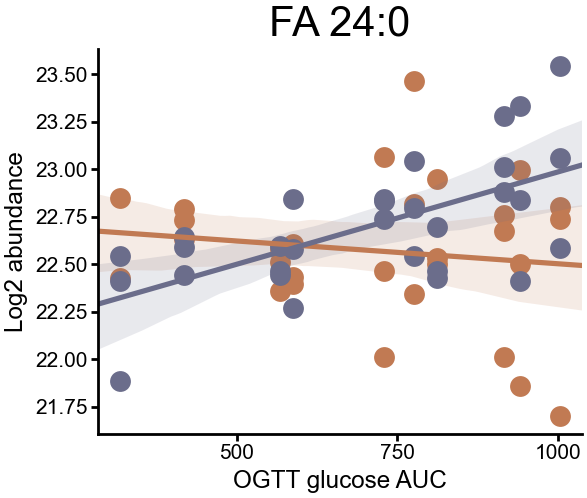

<Figure size 768x576 with 0 Axes>

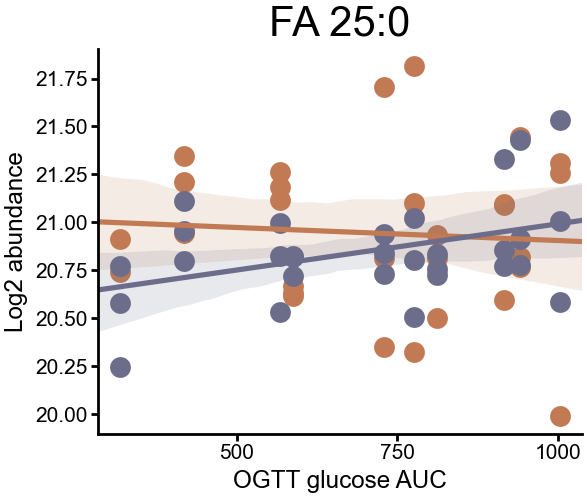

<Figure size 768x576 with 0 Axes>

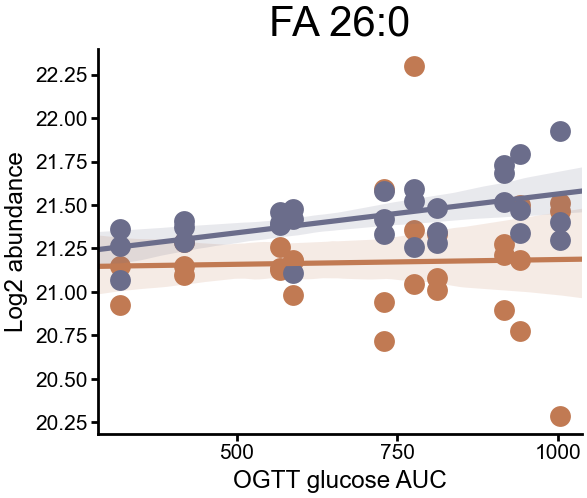

In [237]:
for i, row in data.loc[data['molec_class'] == 'FA'].iterrows():
    plt.figure()
    src.plots.plot_quant_vs_ogtt(i)
    plt.title(row['ID'])